# Term Paper 
## Decision tree for asset price prediction

In [1]:
import pandas as pd
# Set very high resolution for matplotlib plots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    balanced_accuracy_score
)

I utilize the dataset available online, https://www.kaggle.com/datasets/imranbukhari/comprehensive-btcusd-1m-data?select=BTCUSD_1m_Coinbase.csv, which represents the standard 'Open', 'Close', 'Low', 'High', 'Volume', 'Time' data for trading pair BTCUSD on 1 minute timeframe.

In [2]:
df = pd.read_csv("BTCUSD_1m_Coinbase.csv")

# Make sure 'Open time' is in datetime format
df['Open time'] = pd.to_datetime(df['Open time'])

# Set 'Open time' as index
df.set_index('Open time', inplace=True)

# Resample and aggregate
df = df.resample('60T').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

df = df.tail(10100)


## The Elder Impulse System

The Elder Impulse System was designed by Alexander Elder and featured in his book Come Into My Trading Room. According to Elder, “the system identifies inflection points where a trend speeds up or slows down.” The Impulse System is based on two indicators: a 13-day exponential moving average and the MACD-Histogram. The moving average identifies the trend, while the MACD-Histogram measures momentum. As a result, the Impulse System combines trend following and momentum to identify tradable impulses. This unique indicator combination is color coded into the price bars for easy reference.

Green Price Bar: (13-period EMA > previous 13-period EMA) and 
                 (MACD-Histogram > previous period's MACD-Histogram)

Red Price Bar: (13-period EMA < previous 13-period EMA) and 
               (MACD-Histogram < previous period's MACD-Histogram)

Price bars are colored blue when conditions for a Red Price Bar or 
Green Price Bar is not met. The MACD-Histogram is based on MACD(12,26,9). 

Green price bars show that the bulls are in control of trend and momentum as both the 13-day EMA and MACD-Histogram are rising. A red price bar indicates that the bears have taken control because the 13-day EMA and MACD-Histogram are falling. A blue price bar indicates mixed technical signals— neither buying nor selling pressure predominating.

In [3]:
# --- Commonly used EMA: 13, 26, 52
df['EMA_13'] = df['Close'].ewm(span=13, adjust=False).mean().shift(1)
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean().shift(1)
df['EMA_52'] = df['Close'].ewm(span=52, adjust=False).mean().shift(1)

# Crossover signal
df['EMA_13_26_Crossover'] = np.where(
    df['EMA_13'] > df['EMA_26'], 1,   # Bullish
    # else:
    -1                                # Bearish
)


# --- Elder Impulce system coloring
# Step 1: Calculate MACD histogram
# --- MACD histogram
ema_12 = df['Close'].ewm(span=12, adjust=False).mean().shift(1)
ema_26 = df['Close'].ewm(span=26, adjust=False).mean().shift(1)
df['MACD_Line'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD_Line'] - df['Signal_Line']

# Step 2: Shift indicators to make them realistically usable at current bar
df['EMA_13_L1'] = df['EMA_13'].shift(1)
df['EMA_26_L1'] = df['EMA_26'].shift(1)
df['MACD_Hist_L1'] = df['MACD_Hist'].shift(1)

# Step 3: Introduce coloring based on predefined conditions
def color_bar(row):
    if pd.isna(row['EMA_13']) or pd.isna(row['EMA_13_L1']):
        return None  # Skip early rows
    if row['EMA_13'] > row['EMA_13_L1'] and row['MACD_Hist'] > row['MACD_Hist_L1']:
        return 'Green'
    elif row['EMA_13'] < row['EMA_13_L1'] and row['MACD_Hist'] < row['MACD_Hist_L1']:
        return 'Red'
    else:
        return 'Blue'

df['Bar_Color'] = df.apply(color_bar, axis=1)
df = pd.get_dummies(df, columns=['Bar_Color'])
df['Bar_Color'] = df.apply(color_bar, axis=1)

# --- ADR Indicator ---
df['Range'] = df['High'] - df['Low']
df['ADR_10'] = df['Range'].rolling(window=10).mean().shift(1)


# --- Calculation of price 95%, 50%, 5% quantiles
window = 100
# Calculate rolling percentiles and median, shifted by 1 period
df['Upper 95'] = df['Close'].rolling(window).quantile(0.95).shift(1)
df['Lower 5'] = df['Close'].rolling(window).quantile(0.05).shift(1)
df['Median'] = df['Close'].rolling(window).median().shift(1)



In [4]:
# --- Momentum & Trend ---
df['Close_vs_EMA13'] = (df['Close'] - df['EMA_13']) / df['EMA_13']
df['Close_vs_EMA26'] = (df['Close'] - df['EMA_26']) / df['EMA_26']
df['Close_vs_EMA52'] = (df['Close'] - df['EMA_52']) / df['EMA_52']
df['EMA13_slope'] = (df['EMA_13'] - df['EMA_13_L1']) / df['EMA_13_L1']
df['EMA26_slope'] = (df['EMA_26'] - df['EMA_26_L1']) / df['EMA_26_L1']

# --- MACD momentum ---
df['MACD_Hist_slope'] = df['MACD_Hist'] - df['MACD_Hist_L1']

# --- Volatility-normalized range ---
df['Range_pct'] = df['Range'] / df['Close']
df['ADR_vs_Close'] = df['ADR_10'] / df['Close']

# --- Rolling percentile normalization ---
df['Close_pct_from_upper'] = (df['Upper 95'] - df['Close']) / df['Upper 95']
df['Close_pct_from_lower'] = (df['Close'] - df['Lower 5']) / df['Lower 5']
df['Close_pct_from_median'] = (df['Close'] - df['Median']) / df['Median']

# --- Relative Strength Index ---
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = compute_rsi(df['Close'], window=14).shift(1)  # shift to avoid lookahead

# --- Bollinger Bands --- 
bb_window = 20
bb_std = 2

rolling_mean = df['Close'].rolling(window=bb_window)
df['BB_Middle'] = rolling_mean.mean().shift(1)
df['BB_Upper'] = (rolling_mean.mean() + bb_std * rolling_mean.std()).shift(1)
df['BB_Lower'] = (rolling_mean.mean() - bb_std * rolling_mean.std()).shift(1)

df['Close_vs_BB'] = (df['Close'] - df['BB_Middle']) / (df['BB_Upper'] - df['BB_Lower'])

# ---Volume-Based Features ---
# Volume relative to rolling average (volatility-adjusted volume)
df['Volume_ratio'] = df['Volume'] / df['Volume'].rolling(window=20).mean().shift(1)

# Volume spike indicator
df['Volume_spike'] = (df['Volume_ratio'] > 1.35).astype(int)


feature_cols = [
    'Close_vs_EMA13', 'Close_vs_EMA26','Close_vs_EMA52', 'EMA13_slope', 'EMA26_slope', 'EMA_13_26_Crossover',
    'MACD_Hist', 'MACD_Hist_slope',
    'Range_pct', 'ADR_vs_Close',
    'Close_pct_from_upper', 'Close_pct_from_lower', 'Close_pct_from_median',
    'RSI_14',
    'Close_vs_BB',
    'Volume_ratio',
    'Volume_spike',
    'Bar_Color_Blue', 'Bar_Color_Red', 'Bar_Color_Green'
]

df = df.tail(10000)

In [5]:
import pandas as pd
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: 3 rows (Price + Indicators / MACD / Volume)
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    row_heights=[0.6, 0.2, 0.2],
    vertical_spacing=0.03,
    subplot_titles=('Price & Signals', 'MACD Histogram', 'Volume')
)

# Candles with color
for color, name in [('Green', 'green'), ('Red', 'red'), ('Blue', 'blue')]:
    subset = df[df['Bar_Color'] == color]
    fig.add_trace(go.Candlestick(
        x=subset.index,
        open=subset['Open'],
        high=subset['High'],
        low=subset['Low'],
        close=subset['Close'],
        increasing_line_color=name,
        decreasing_line_color=name,
        showlegend=False
    ), row=1, col=1)

# Add EMA and Rolling Window overlays
fig.add_trace(go.Scatter(
    x=df.index, y=df['EMA_13'],
    line=dict(color='orange', width=1),
    name='EMA 13'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df.index, y=df['EMA_52'],
    line=dict(color='purple', width=1),
    name='EMA 52'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df.index, y=df['Upper 95'],
    line=dict(color='white', width=1, dash='dot'),
    name='Upper 95%'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df.index, y=df['Lower 5'],
    line=dict(color='white', width=1, dash='dot'),
    name='Lower 5%'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df.index, y=df['Median'],
    line=dict(color='cyan', width=1, dash='dash'),
    name='Median'
), row=1, col=1)

# MACD Histogram
fig.add_trace(go.Bar(
    x=df.index,
    y=df['MACD_Hist'],
    marker_color=df['MACD_Hist'].apply(lambda x: 'green' if x >= 0 else 'red'),
    name='MACD Histogram'
), row=2, col=1)

# Volume
fig.add_trace(go.Bar(
    x=df.index,
    y=df['Volume'],
    marker_color='lightgray',
    name='Volume'
), row=3, col=1)

# Final layout tweaks
fig.update_layout(
    title='Trading Dashboard with Custom Coloring and Indicators',
    template='plotly_dark',
    xaxis_rangeslider_visible=False,
    height=900,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)

# Export to HTML
plotly.offline.plot(fig, "CandleDashboard.html")


'temp-plot.html'

In [152]:
# Limit to last 1000 rows
df_last = df.tail(1000)

fig = go.Figure(go.Candlestick(
    x=df_last.index,
    open=df_last['Open'],
    high=df_last['High'],
    low=df_last['Low'],
    close=df_last['Close']
))

fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)


plotly.offline.plot(fig, filename="CandleStick.html")


'CandleStick.html'

In [6]:
RISK_REWARD_RATIO = 3
STOP_LOSS_ATR_MULTIPLIER = 1

# SL and TP levels
df['StopLoss'] = df['ADR_10'] * STOP_LOSS_ATR_MULTIPLIER
df['TakeProfit'] = df['StopLoss'] * RISK_REWARD_RATIO

df['SL_Long'] = df['Open'] - df['StopLoss']
df['TP_Long'] = df['Open'] + df['TakeProfit']
df['SL_Short'] = df['Open'] + df['StopLoss']
df['TP_Short'] = df['Open'] - df['TakeProfit'] 

def simulate_trade_classification(df):
    trade_signals = ['None'] * len(df)
    close_row_num = [0] * len(df)
    duration = [0] * len(df)
    i = 0
    while i < len(df):
        row = df.iloc[i]

        # Simulate Long
        for j in range(i, len(df)):
            future = df.iloc[j]
            if future['Low'] <= row['SL_Long']:
                break
            elif future['High'] >= row['TP_Long']:
                trade_signals[i] = 'Long'
                duration[i] = j - i + 1
                close_row_num[i] = j
                break

        # Simulate Short
        for j in range(i, len(df)):
            future = df.iloc[j]
            if future['High'] >= row['SL_Short']:
                break
            elif future['Low'] <= row['TP_Short']:
                trade_signals[i] = 'Short'
                duration[i] = j - i + 1
                close_row_num[i] = j
                break

        i += 1

    df['Trade_Signal'] = trade_signals
    df['Duration'] = duration
    df['Close Row'] = close_row_num
    return df

df = simulate_trade_classification(df)


In [7]:
def compute_active_trades(df):
    active_trades = []
    close_rows = df['Close Row'].values

    for i in range(len(df)):
        # Include trades that are open at or before row i and close after or at i
        count = ((close_rows[:i+1] >= i) & (close_rows[:i+1] != 0)).sum()
        active_trades.append(count)

    df['Active_Trades'] = active_trades
    return df


df = compute_active_trades(df)

import numpy as np

df['Return_Long'] = np.where(
    df['Trade_Signal'] == 'Long',
    df['TakeProfit'] / df['Open'],
    np.nan
)

df['Return_Short'] = np.where(
    df['Trade_Signal'] == 'Short',
    df['TakeProfit'] / df['Open'],
    np.nan
)

df['Return'] = df['TakeProfit'] / df['Open']



print(df['Return_Short'].sum())
print(df['Return_Long'].sum())



54.6800426541369
61.35908856168426


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

y = df['Trade_Signal_max24bars'] 
X = df[feature_cols].copy()

""" # First split: separate out the test set (20% of data)
features_temp, features_test, labels_temp, labels_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Second split: split the remaining data into training (60% of total) and validation (20% of total)
features_train, features_val, labels_train, labels_val = train_test_split(
    features_temp,
    labels_temp,
    test_size=0.25,  # 0.25 of the 0.8 = 0.2 of the total
    random_state=42
) """

# Find how many samples
n_samples = len(X)

# First split: 80% for train+val, 20% for test
n_trainval = int(n_samples * 0.8)

# Second split inside trainval: 75% train (60% total), 25% val (20% total)
n_train = int(n_trainval * 0.75)

# Chronological slicing
features_train = X.iloc[:n_train]
labels_train = y.iloc[:n_train]

features_val = X.iloc[n_train:n_trainval]
labels_val = y.iloc[n_train:n_trainval]

features_test = X.iloc[n_trainval:]
labels_test = y.iloc[n_trainval:]


print(f"Training set size: {features_train.shape[0]} rows")
print(f"Validation set size: {features_val.shape[0]} rows")
print(f"Test set size: {features_test.shape[0]} rows")

model_decision_tree_classifier = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=20,
    random_state=42
)

model_decision_tree_classifier.fit(features_train, labels_train)


Training set size: 6000 rows
Validation set size: 2000 rows
Test set size: 2000 rows


DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)

Training accuracy: 0.54
Training balanced accuracy: 0.38

Confusion matrix (training set):


<Figure size 3600x3600 with 0 Axes>

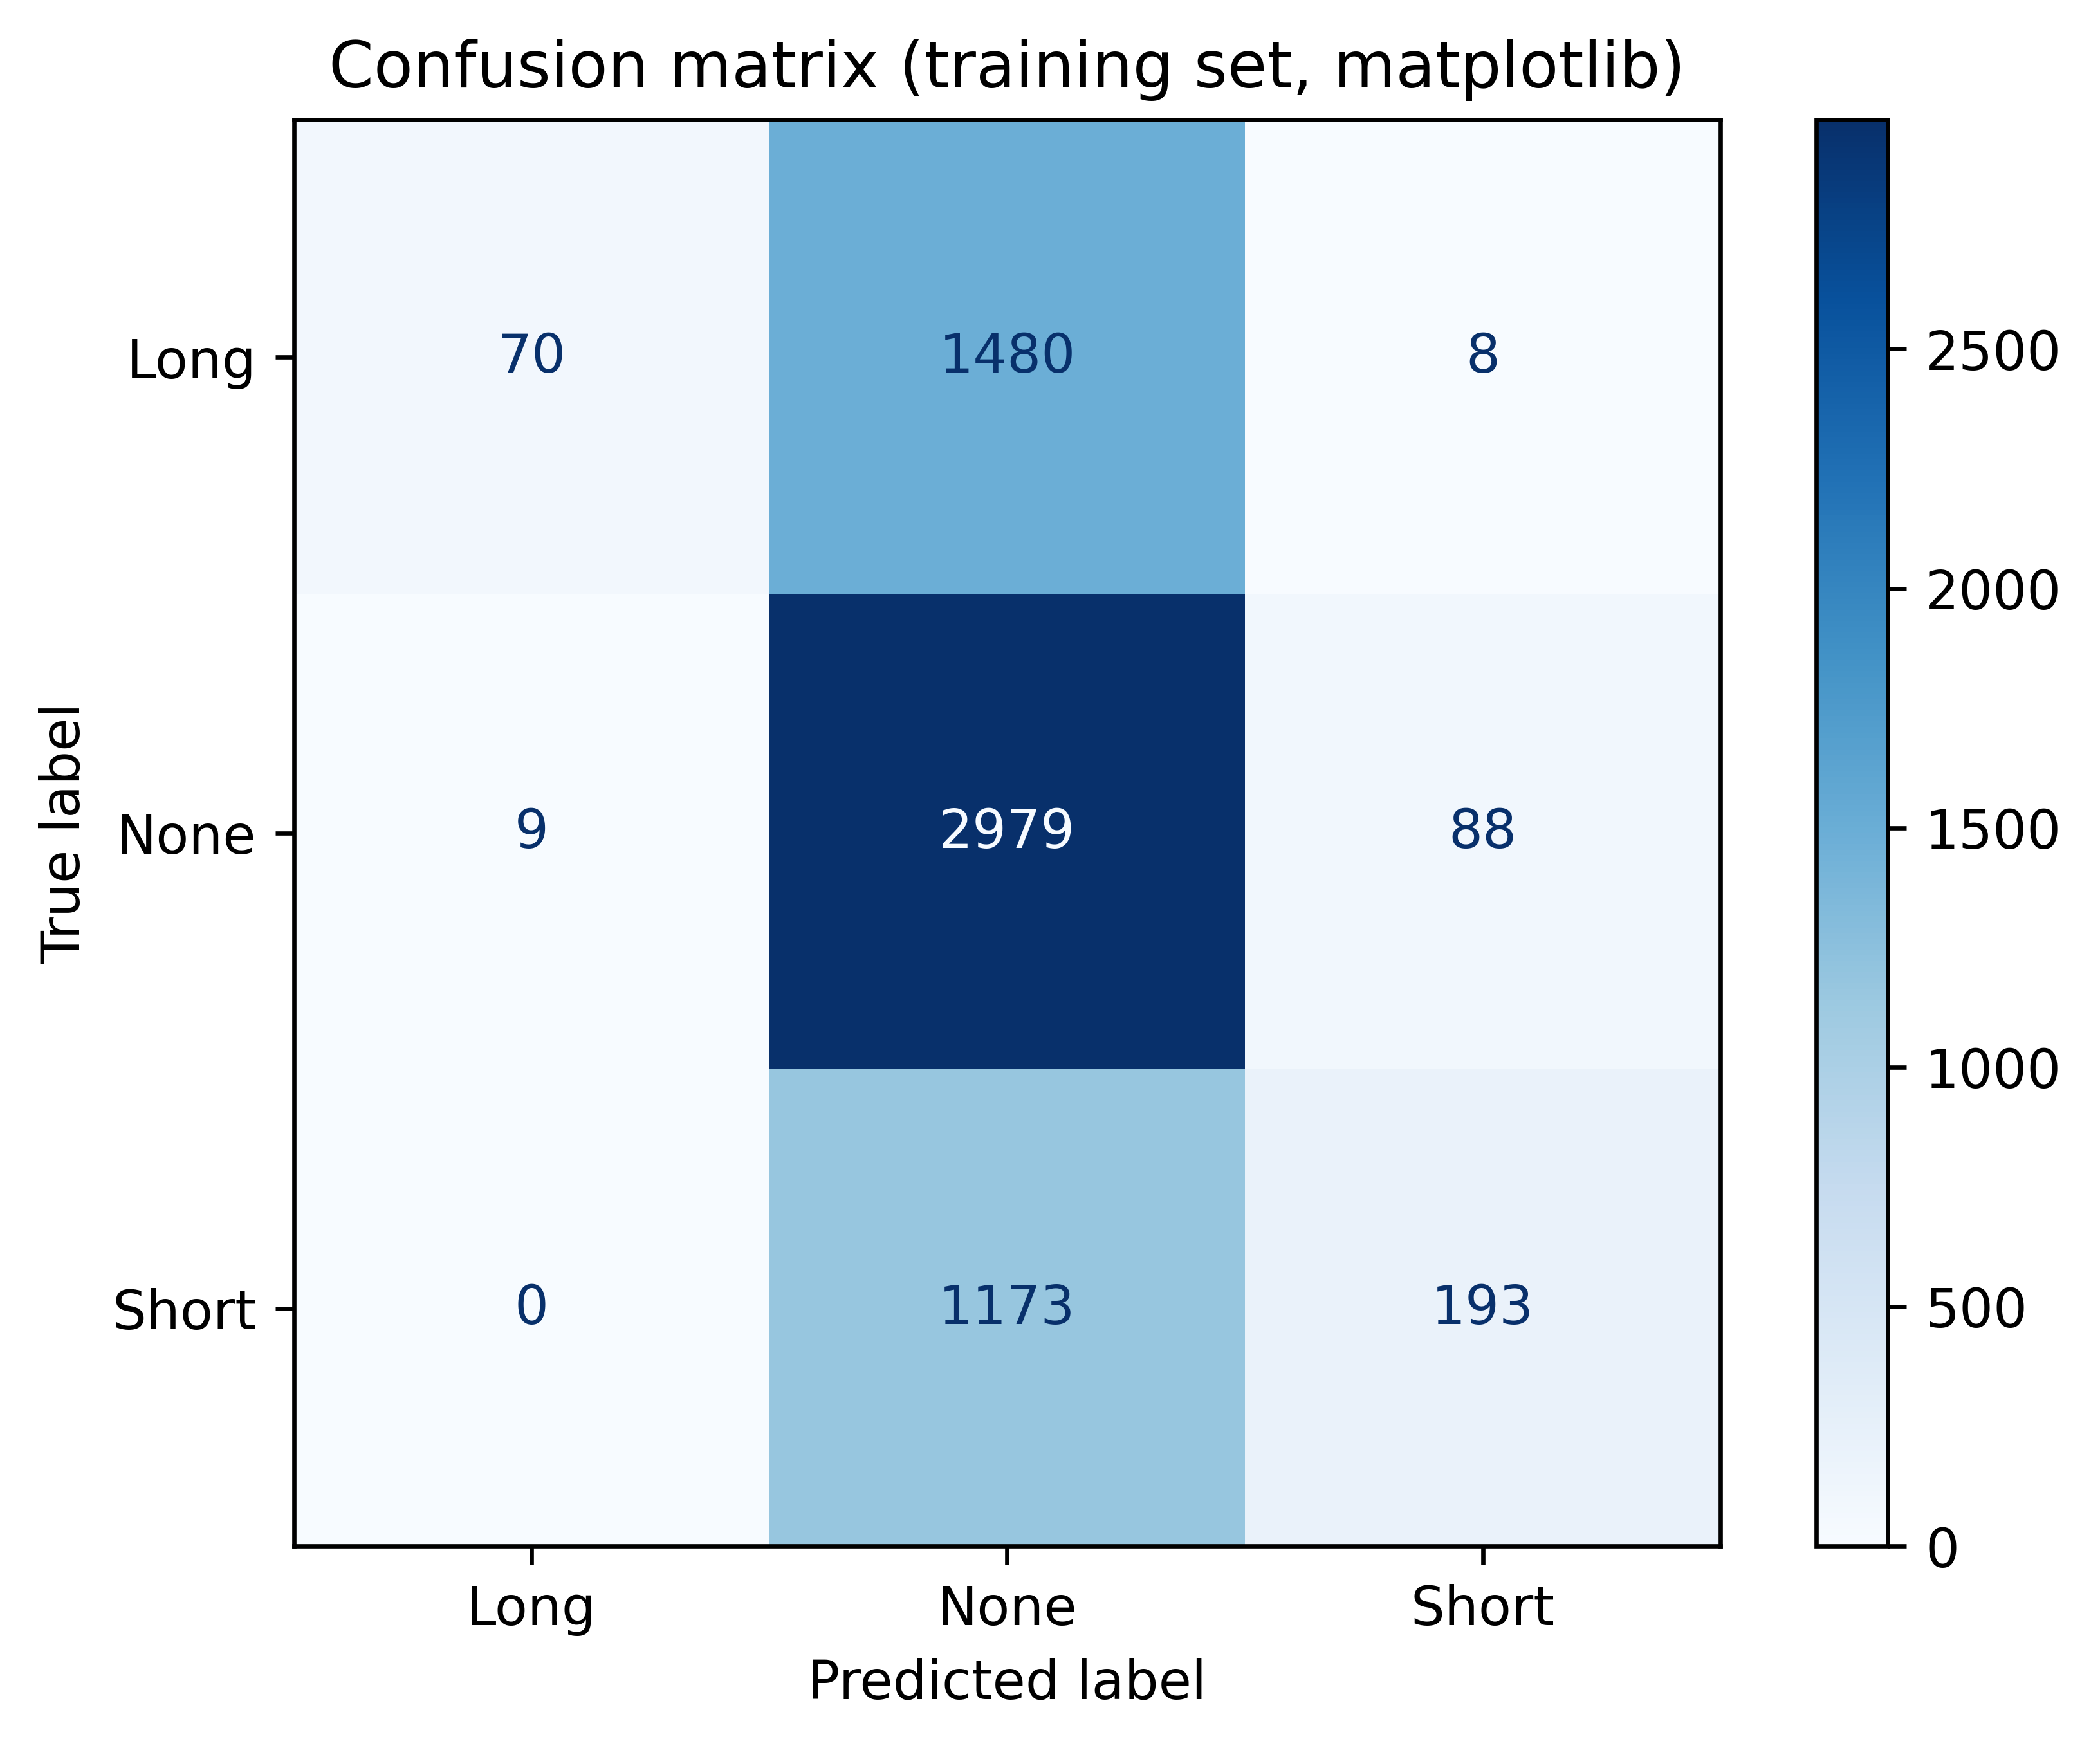


Classification report (training set):

              precision    recall  f1-score   support

        Long       0.89      0.04      0.09      1558
        None       0.53      0.97      0.68      3076
       Short       0.67      0.14      0.23      1366

    accuracy                           0.54      6000
   macro avg       0.69      0.38      0.33      6000
weighted avg       0.65      0.54      0.43      6000



In [9]:
# Predict on the training set
train_predictions = model_decision_tree_classifier.predict(features_train)

# Calculate multiple performance metrics
train_accuracy = accuracy_score(labels_train, train_predictions)
train_balanced_accuracy = balanced_accuracy_score(labels_train, train_predictions)
train_conf_matrix = confusion_matrix(labels_train, train_predictions, labels=sorted(df['Trade_Signal'].unique()))
train_class_report = classification_report(labels_train, train_predictions, zero_division=0)

print(f"Training accuracy: {train_accuracy:.2f}")
print(f"Training balanced accuracy: {train_balanced_accuracy:.2f}")
print("\nConfusion matrix (training set):")
train_conf_display = ConfusionMatrixDisplay(
    confusion_matrix=train_conf_matrix,
    display_labels=sorted(df['Trade_Signal'].unique())
)

# Adjust figure size here
plt.figure(figsize=(6, 6))  # Adjust as needed
train_conf_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix (training set, matplotlib)")
plt.show()

print("\nClassification report (training set):\n")
print(train_class_report)

Validation accuracy: 0.52
Validation balanced accuracy: 0.36

Confusion matrix (validation set):


<Figure size 600x600 with 0 Axes>

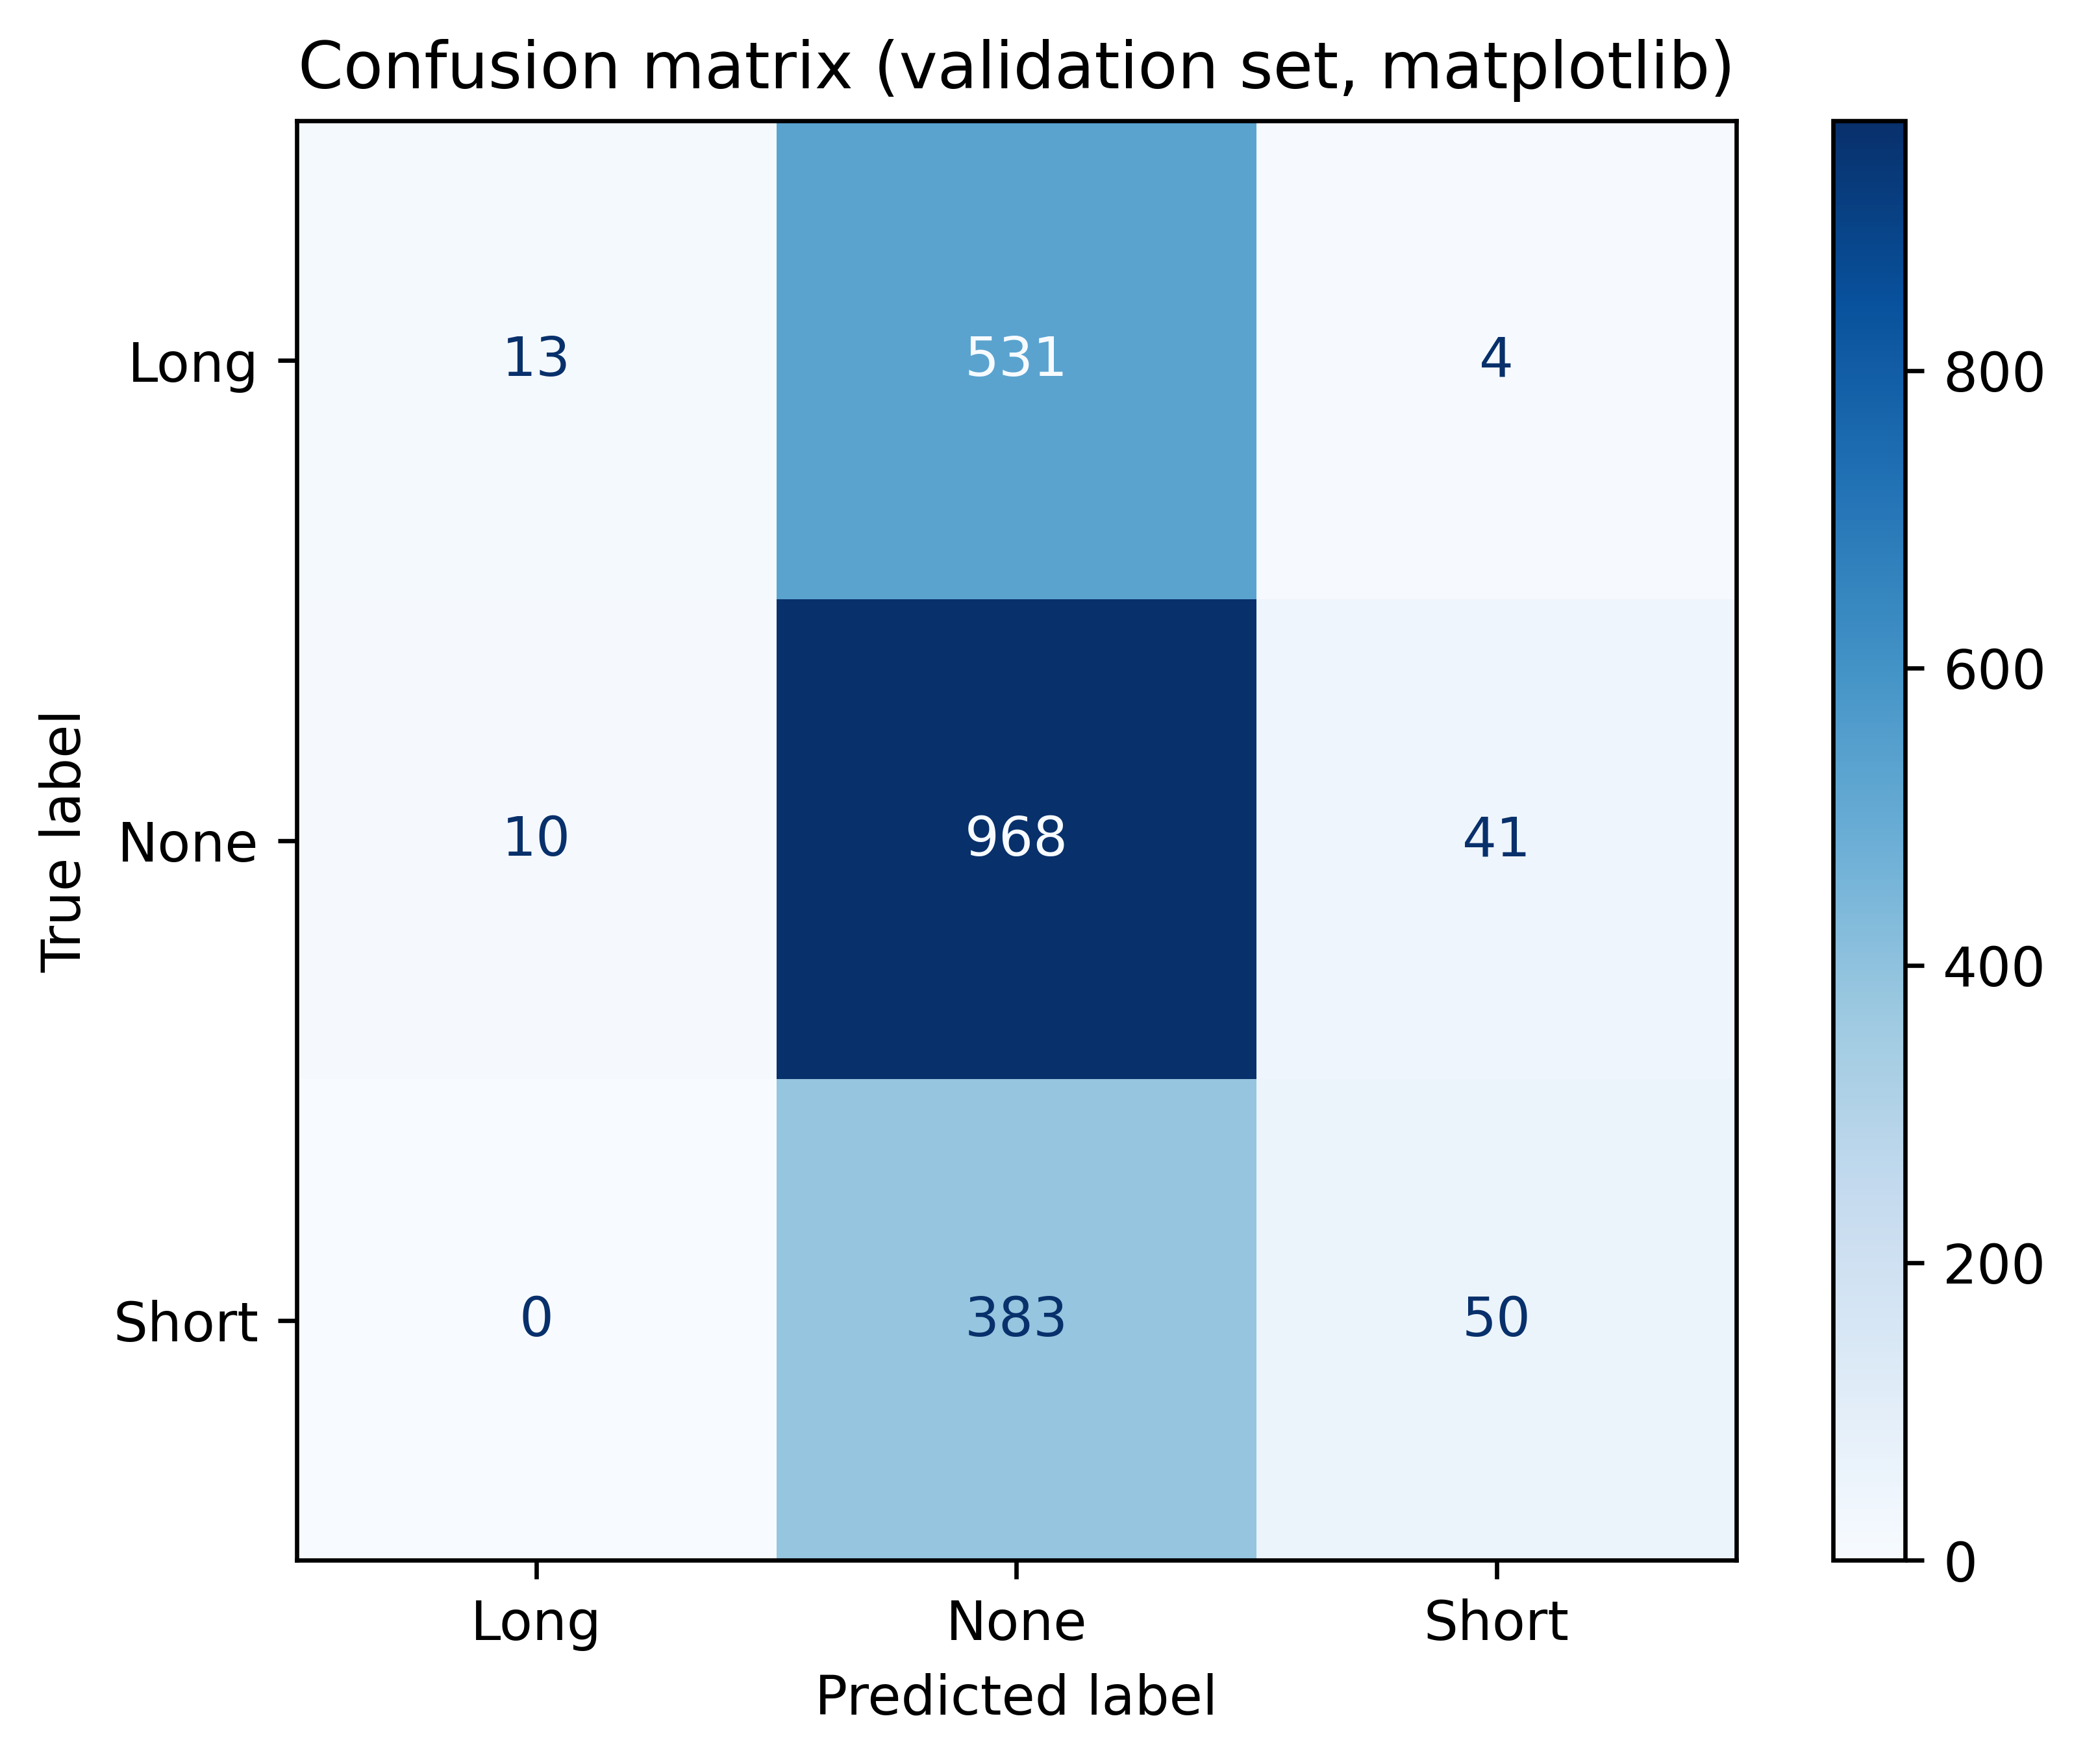


Classification report (validation set):

              precision    recall  f1-score   support

        Long       0.57      0.02      0.05       548
        None       0.51      0.95      0.67      1019
       Short       0.53      0.12      0.19       433

    accuracy                           0.52      2000
   macro avg       0.54      0.36      0.30      2000
weighted avg       0.53      0.52      0.39      2000



In [10]:
# Predict on the validation set
val_predictions = model_decision_tree_classifier.predict(features_val)

# Calculate multiple performance metrics
val_accuracy = accuracy_score(labels_val, val_predictions)
val_balanced_accuracy = balanced_accuracy_score(labels_val, val_predictions)
val_conf_matrix = confusion_matrix(labels_val, val_predictions, labels=sorted(df['Trade_Signal'].unique()))
val_class_report = classification_report(labels_val, val_predictions, zero_division=0)

print(f"Validation accuracy: {val_accuracy:.2f}")
print(f"Validation balanced accuracy: {val_balanced_accuracy:.2f}")
print("\nConfusion matrix (validation set):")
val_conf_display = ConfusionMatrixDisplay(
    confusion_matrix=val_conf_matrix,
    display_labels=sorted(df['Trade_Signal'].unique())
)

# Adjust figure size here
plt.figure(figsize=(1, 1))  # You can modify this to fit your needs
val_conf_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix (validation set, matplotlib)")
plt.show()

print("\nClassification report (validation set):\n")
print(val_class_report)

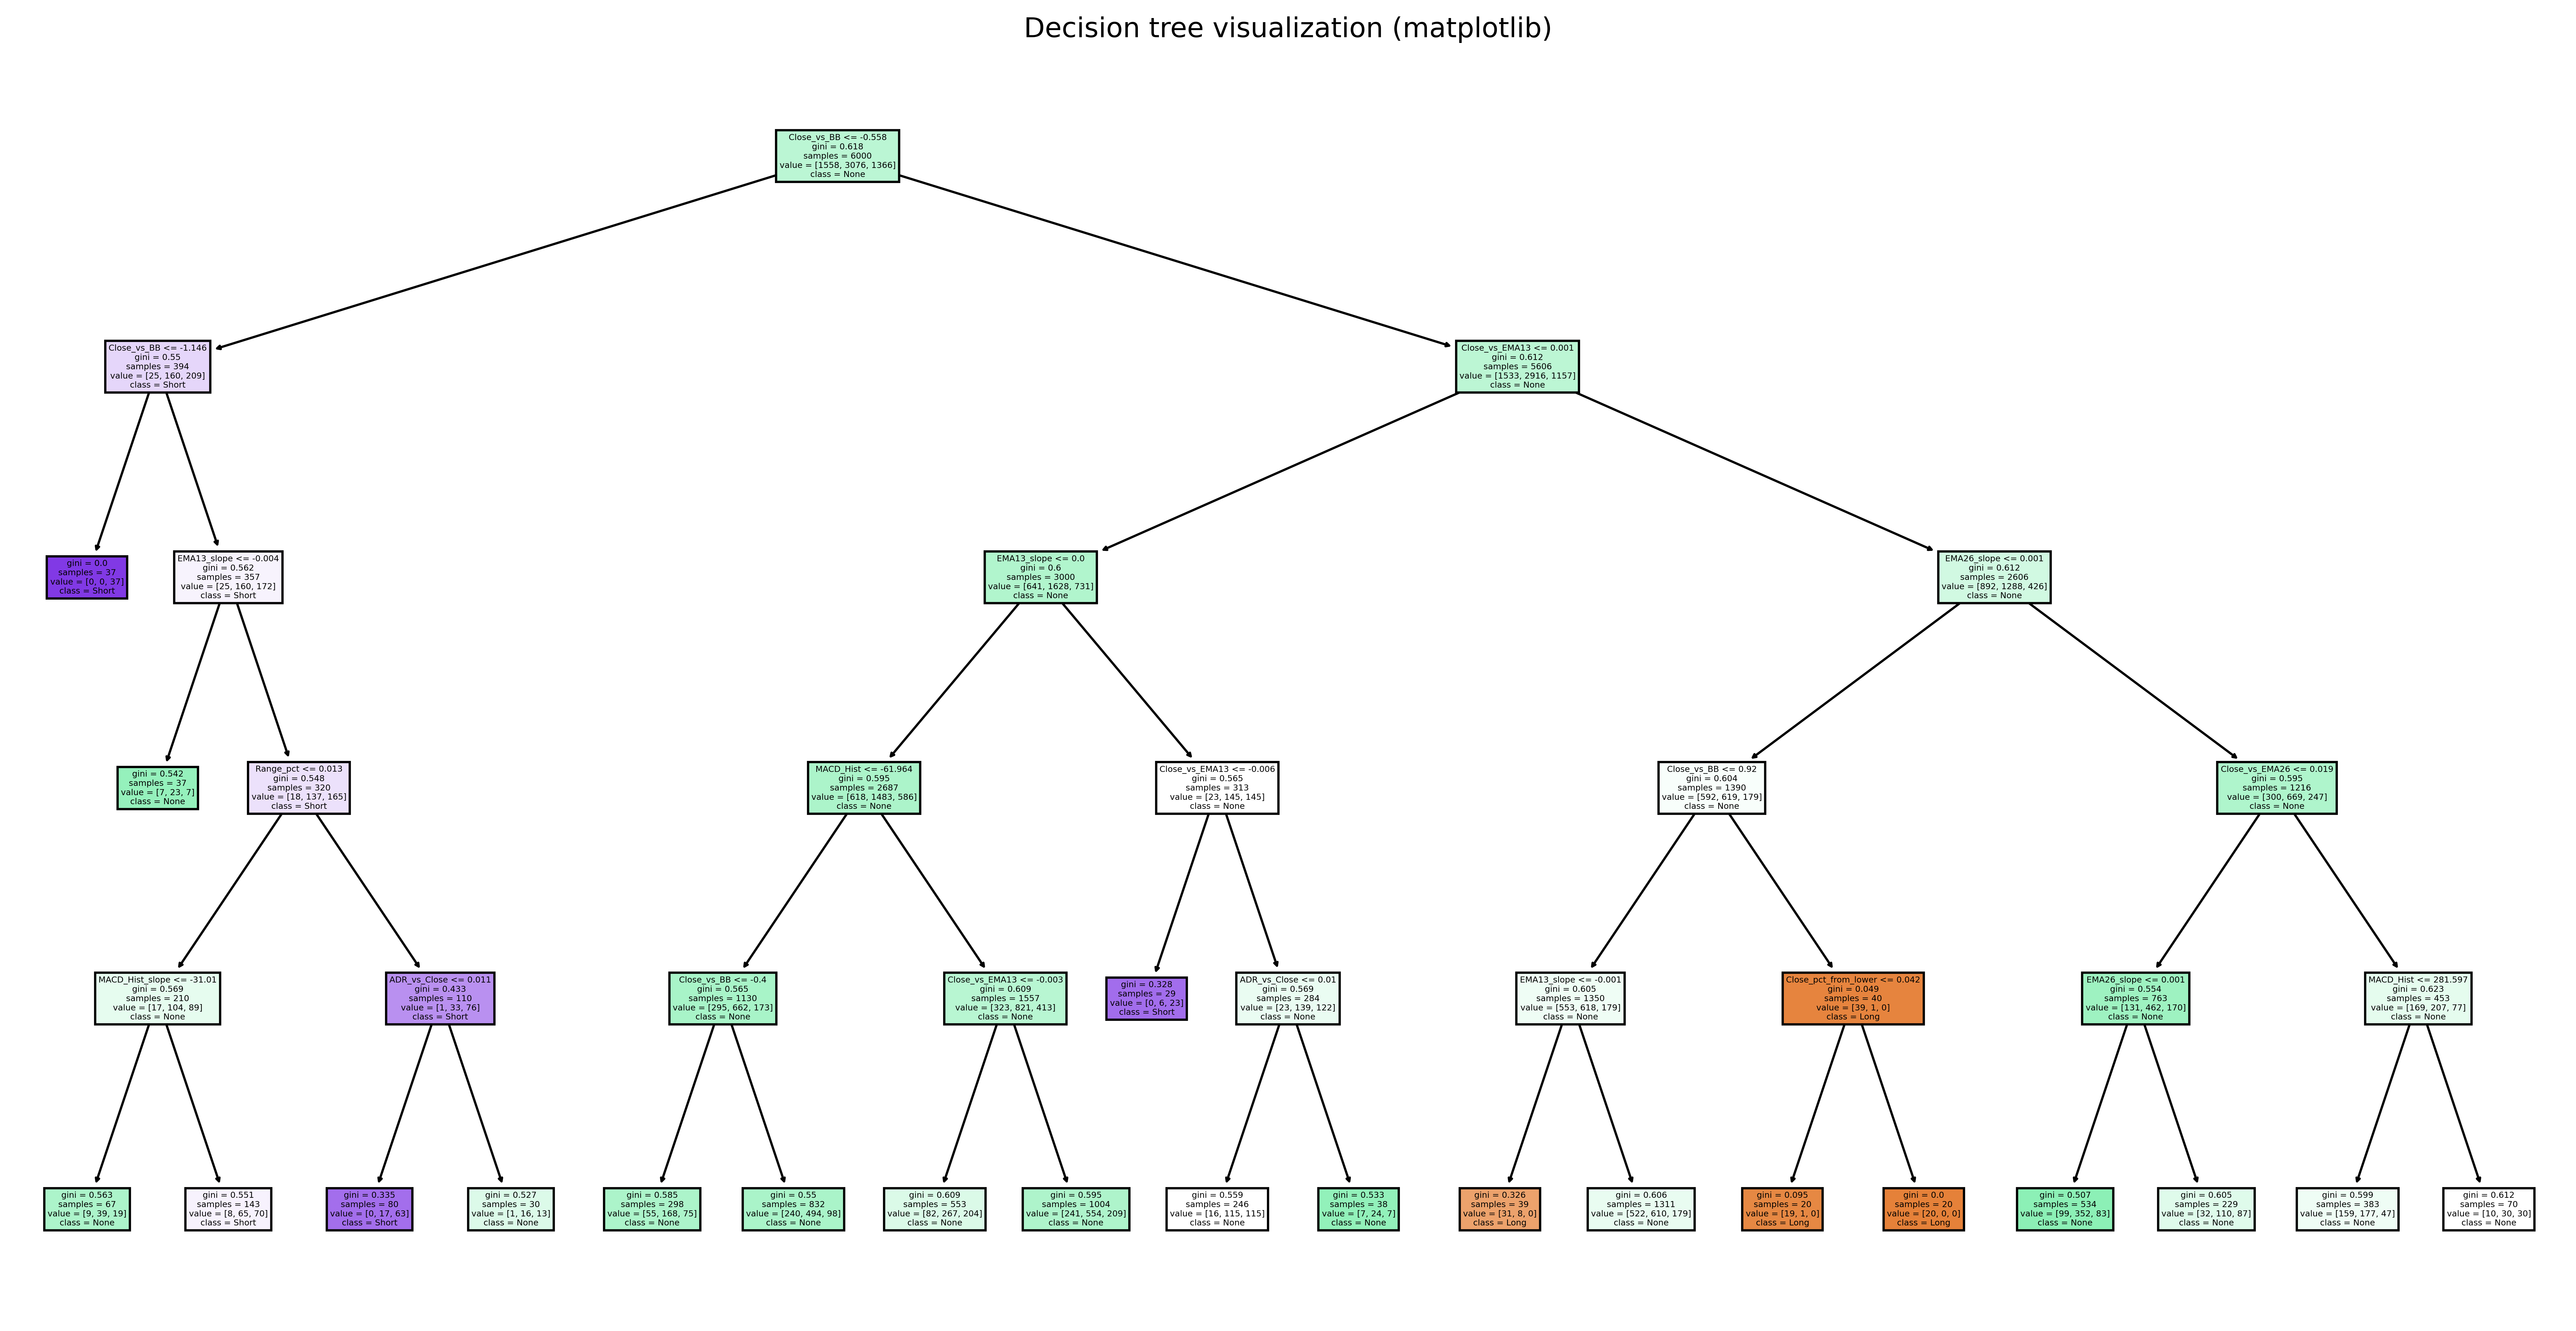

In [11]:
plt.figure(figsize=(20, 10))
plot_tree(
    model_decision_tree_classifier,
    feature_names=feature_cols,
    class_names=[str(cls) for cls in sorted(df['Trade_Signal'].unique())],
    filled=True
)
plt.title("Decision tree visualization (matplotlib)")
plt.show()

## The Elder Impulse System

In [278]:
%reset -f

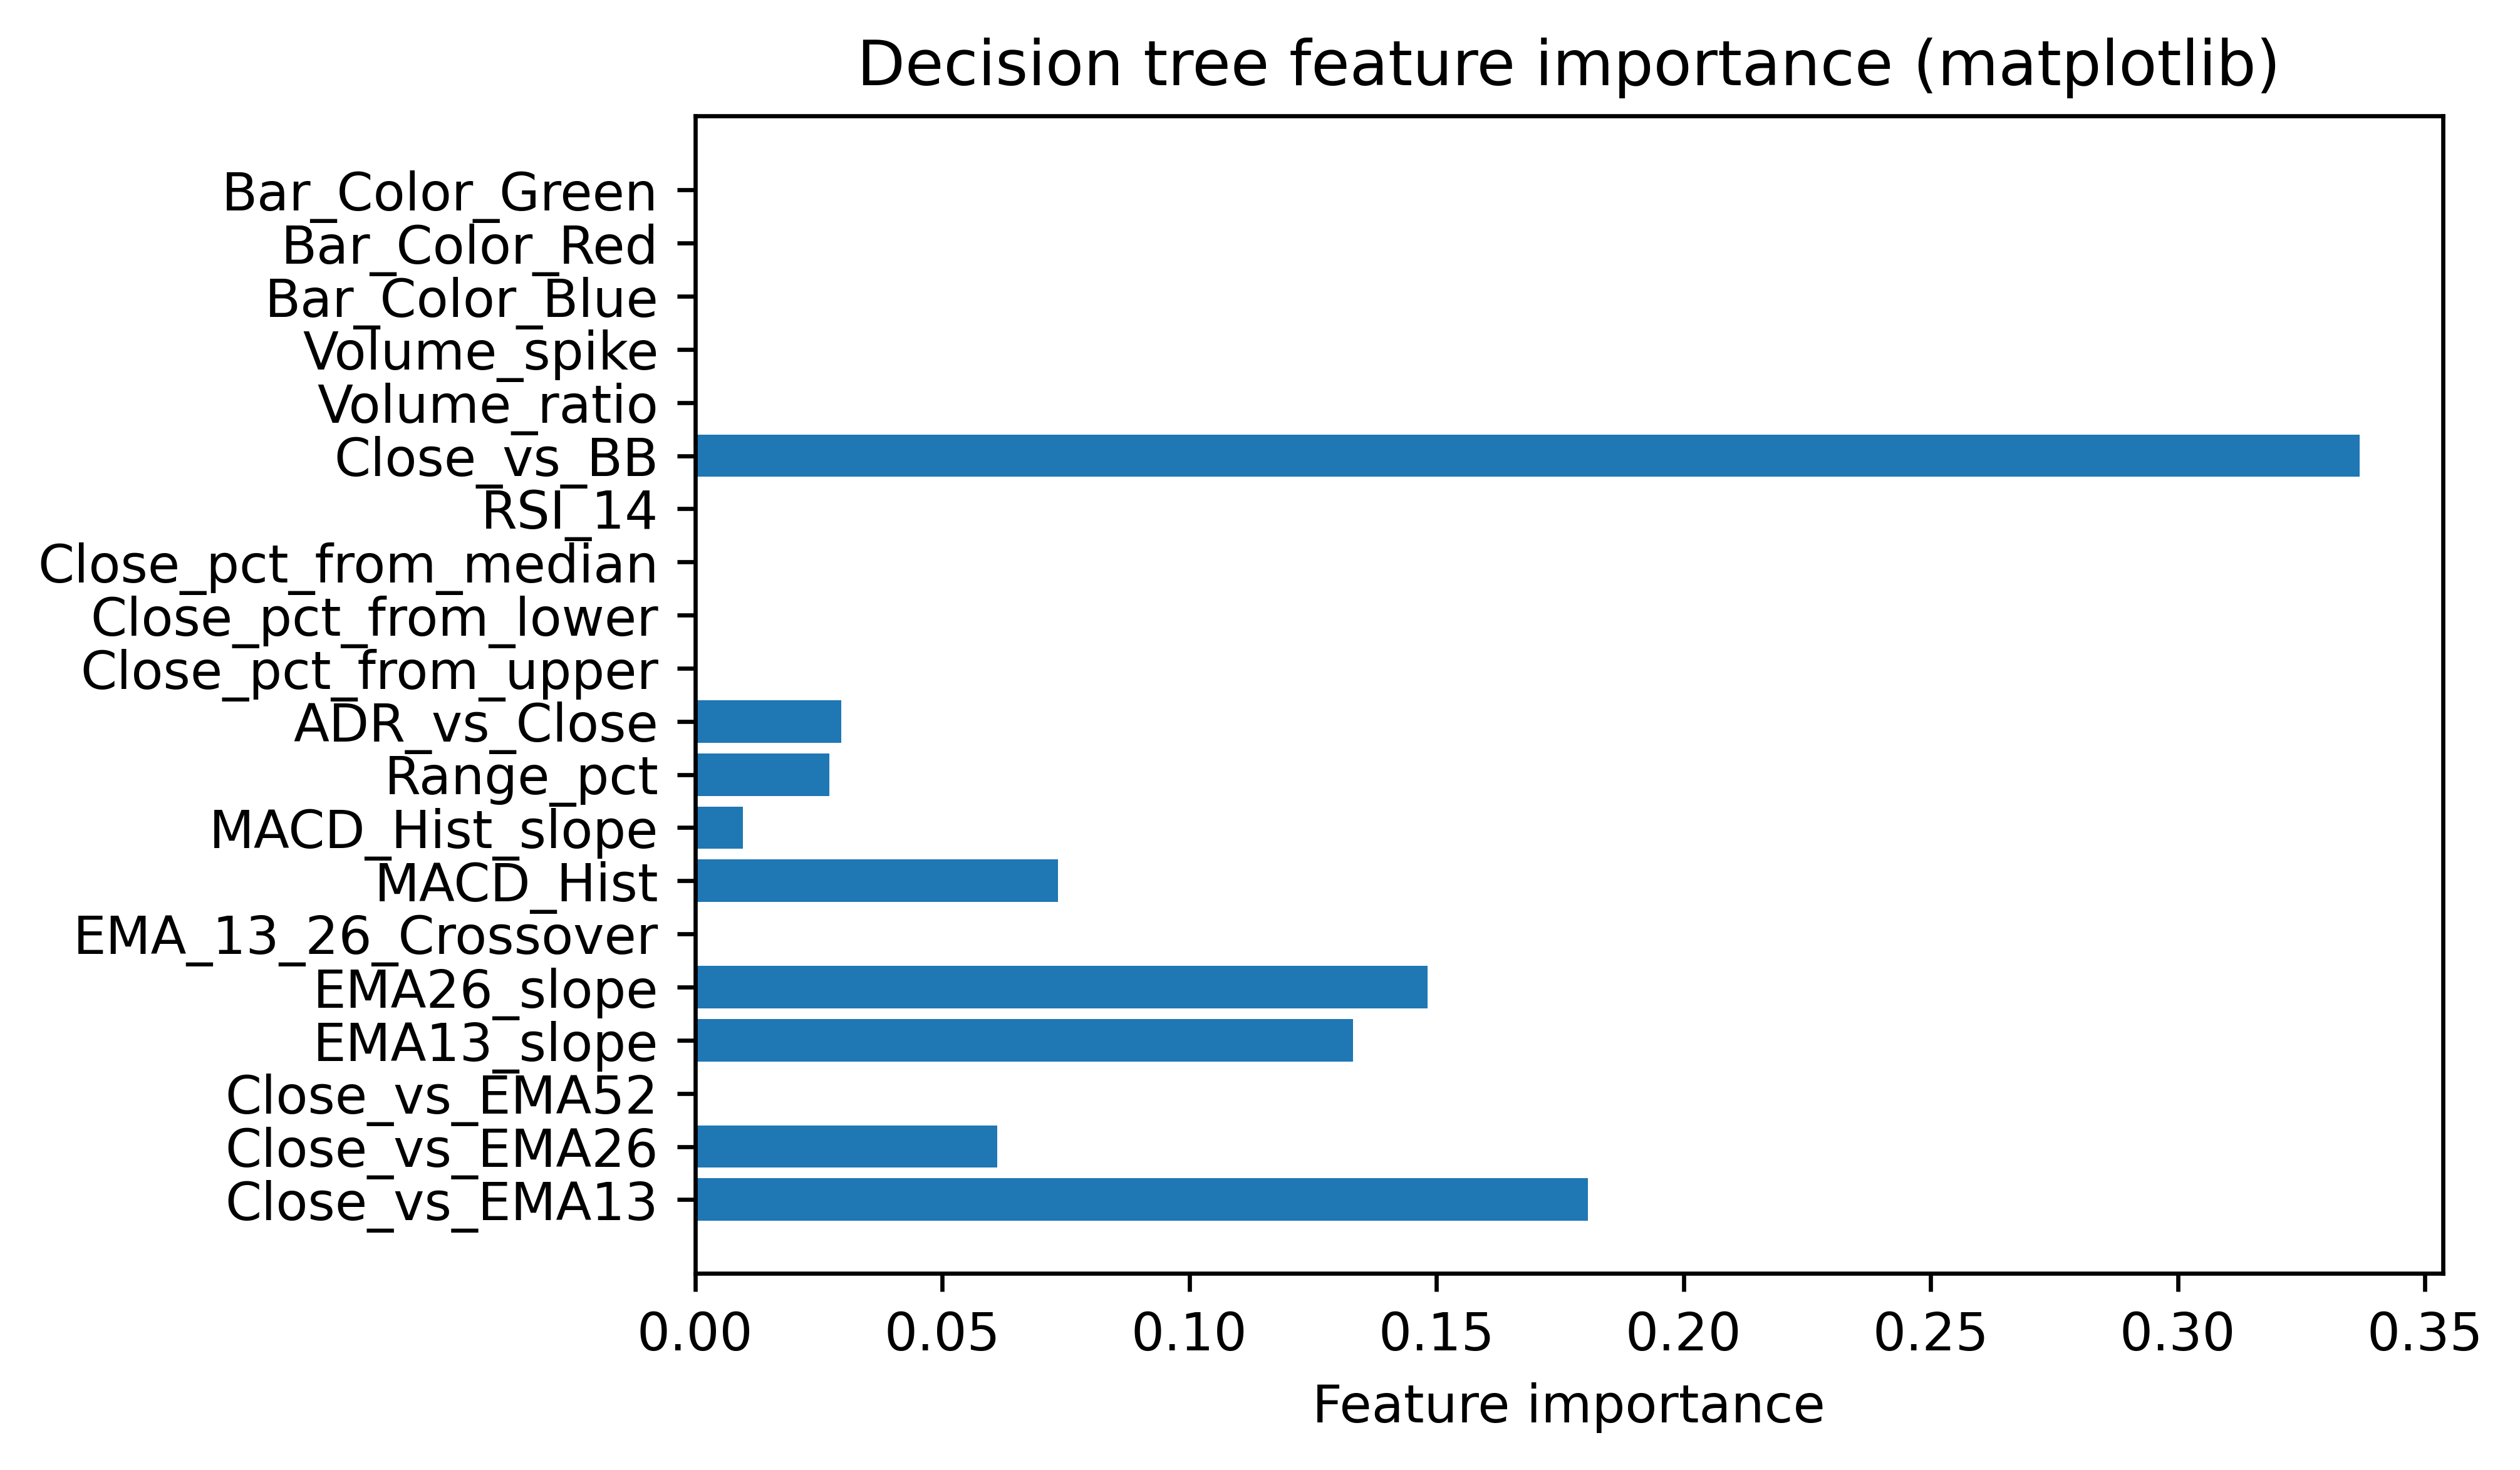

In [12]:
feature_importances_decision_tree = model_decision_tree_classifier.feature_importances_

# Matplotlib version
plt.figure(figsize=(6,4))
plt.barh(X.columns, feature_importances_decision_tree)
plt.xlabel("Feature importance")
plt.title("Decision tree feature importance (matplotlib)")
plt.show()

In [11]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Chronological slicing
features_train = X.iloc[:n_trainval]
labels_train = y.iloc[:n_trainval]

# Define Bayesian Optimization function
def objective(trial):
    # Handle max_depth (include None as an option)
    max_depth = trial.suggest_categorical('max_depth', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, None])

    # Other hyperparameters
    criterion = trial.suggest_categorical('criterion', ["gini", "entropy"])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)  # Matches [2, 5, 10]
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20, step=2)  # Matches [1, 2, 5]

    # Define model with suggested parameters
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Cross-validation
    score = cross_val_score(model, features_train, labels_train, cv=5, scoring='accuracy').mean()

    return score  # Optuna maximizes this value

# Run Bayesian Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Extract best hyperparameters
best_params = study.best_params
best_score = study.best_value

# Print best parameters
print(f"Best Max Depth: {best_params['max_depth']}")
print(f"Best Criterion: {best_params['criterion']}")
print(f"Best Min Samples Split: {best_params['min_samples_split']}")
print(f"Best Min Samples Leaf: {best_params['min_samples_leaf']}")
print(f"Best Validation Accuracy: {best_score:.4f}")


/Users/Robert/Downloads/ML for Social Sciences JCM072/Term_Paper/localpyenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

[I 2025-04-28 13:04:34,064] A new study created in memory with name: no-name-46be5e13-b743-41ef-baf9-309e5276ce88
[I 2025-04-28 13:04:34,223] Trial 0 finished with value: 0.78325 and parameters: {'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 4, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.78325.
[I 2025-04-28 13:04:34,356] Trial 1 finished with value: 0.779875 and parameters: {'max_depth': 2, 'criterion': 'entropy', 'min_samples_split': 12, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.78325.
[I 2025-04-28 13:04:34,501] Trial 2 finished with value: 0.78325 and parameters: {'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.78325.
[I 20

Best Max Depth: 5
Best Criterion: entropy
Best Min Samples Split: 8
Best Min Samples Leaf: 16
Best Validation Accuracy: 0.7869


In [ ]:
from sklearn.metrics import make_scorer
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

def custom_directional_score(y_true, y_pred):
    score = 0
    for idx, (true, pred) in enumerate(zip(y_true, y_pred)):
        return_value = df.loc[y_true.index[idx], 'Return']  # Get return from df by index

        if true == pred:
            score += return_value  # reward = actual return of the trade
        elif (true == 'Long' and pred == 'Short') or (true == 'Short' and pred == 'Long'):
            score -= return_value / 3  # big penalty for wrong trade direction
        elif (true == 'None' and (pred == 'Long' or pred == 'Short')):
            score -= return_value / 3  # penalty for predicting a trade when it should be None
        else:
            score -= 0.003  # missing a trade = tolerated
    final_score = score # normalize
    return final_score


custom_scorer = make_scorer(custom_directional_score, greater_is_better=True)

# def custom_directional_score(y_true, y_pred):
#     score = 0
#     for true, pred in zip(y_true, y_pred):
#         if true == pred:
#             score += 3  # correct prediction
#         elif (true == 'Long' and pred == 'Short') or (true == 'Short' and pred == 'Long'):
#             score -= 3  # big penalty for wrong trade direction
#         elif (true == 'None' and (pred == 'Long' or pred == 'Short')):
#             score -= 2  # penalty for predicting a trade when it should be None
#         else:
#             score -= 0.1  # small mistakes (like predicting None instead of trade) are tolerated
#     return score / len(y_true)  # normalize score

# custom_scorer = make_scorer(custom_directional_score, greater_is_better=True)


# Define Bayesian Optimization function
def objective(trial):
    # Handle max_depth (include None as an option)
    max_depth = trial.suggest_categorical('max_depth', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, None])

    # Other hyperparameters
    criterion = trial.suggest_categorical('criterion', ["gini", "entropy"])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)  # Matches [2, 5, 10]
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20, step=2)  # Matches [1, 2, 5]

    # Define model with suggested parameters
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Cross-validation
    score = cross_val_score(model, features_train, labels_train, cv=5, scoring=custom_scorer).mean()

    return score  # Optuna maximizes this value

# Run Bayesian Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Extract best hyperparameters
best_params = study.best_params
best_score = study.best_value

# Print best parameters
print(f"Best Max Depth: {best_params['max_depth']}")
print(f"Best Criterion: {best_params['criterion']}")
print(f"Best Min Samples Split: {best_params['min_samples_split']}")
print(f"Best Min Samples Leaf: {best_params['min_samples_leaf']}")
print(f"Best Validation Accuracy: {best_score:.4f}")


[I 2025-04-28 10:36:01,626] A new study created in memory with name: no-name-2fd9e2be-394d-4e8a-8c4e-21d003765659
[I 2025-04-28 10:36:02,190] Trial 0 finished with value: 26.289441435189236 and parameters: {'max_depth': None, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 0 with value: 26.289441435189236.
[I 2025-04-28 10:36:02,425] Trial 1 finished with value: 29.84223824764112 and parameters: {'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 14}. Best is trial 1 with value: 29.84223824764112.
[I 2025-04-28 10:36:02,618] Trial 2 finished with value: 29.749513648454503 and parameters: {'max_depth': 2, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 1 with value: 29.84223824764112.
[I 2025-04-28 10:36:02,922] Trial 3 finished with value: 29.77429973793236 and parameters: {'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 12, 'min_samples_leaf': 18}. Best is trial 1 with va

Best Max Depth: 5
Best Criterion: entropy
Best Min Samples Split: 20
Best Min Samples Leaf: 16
Best Validation Accuracy: 29.9088


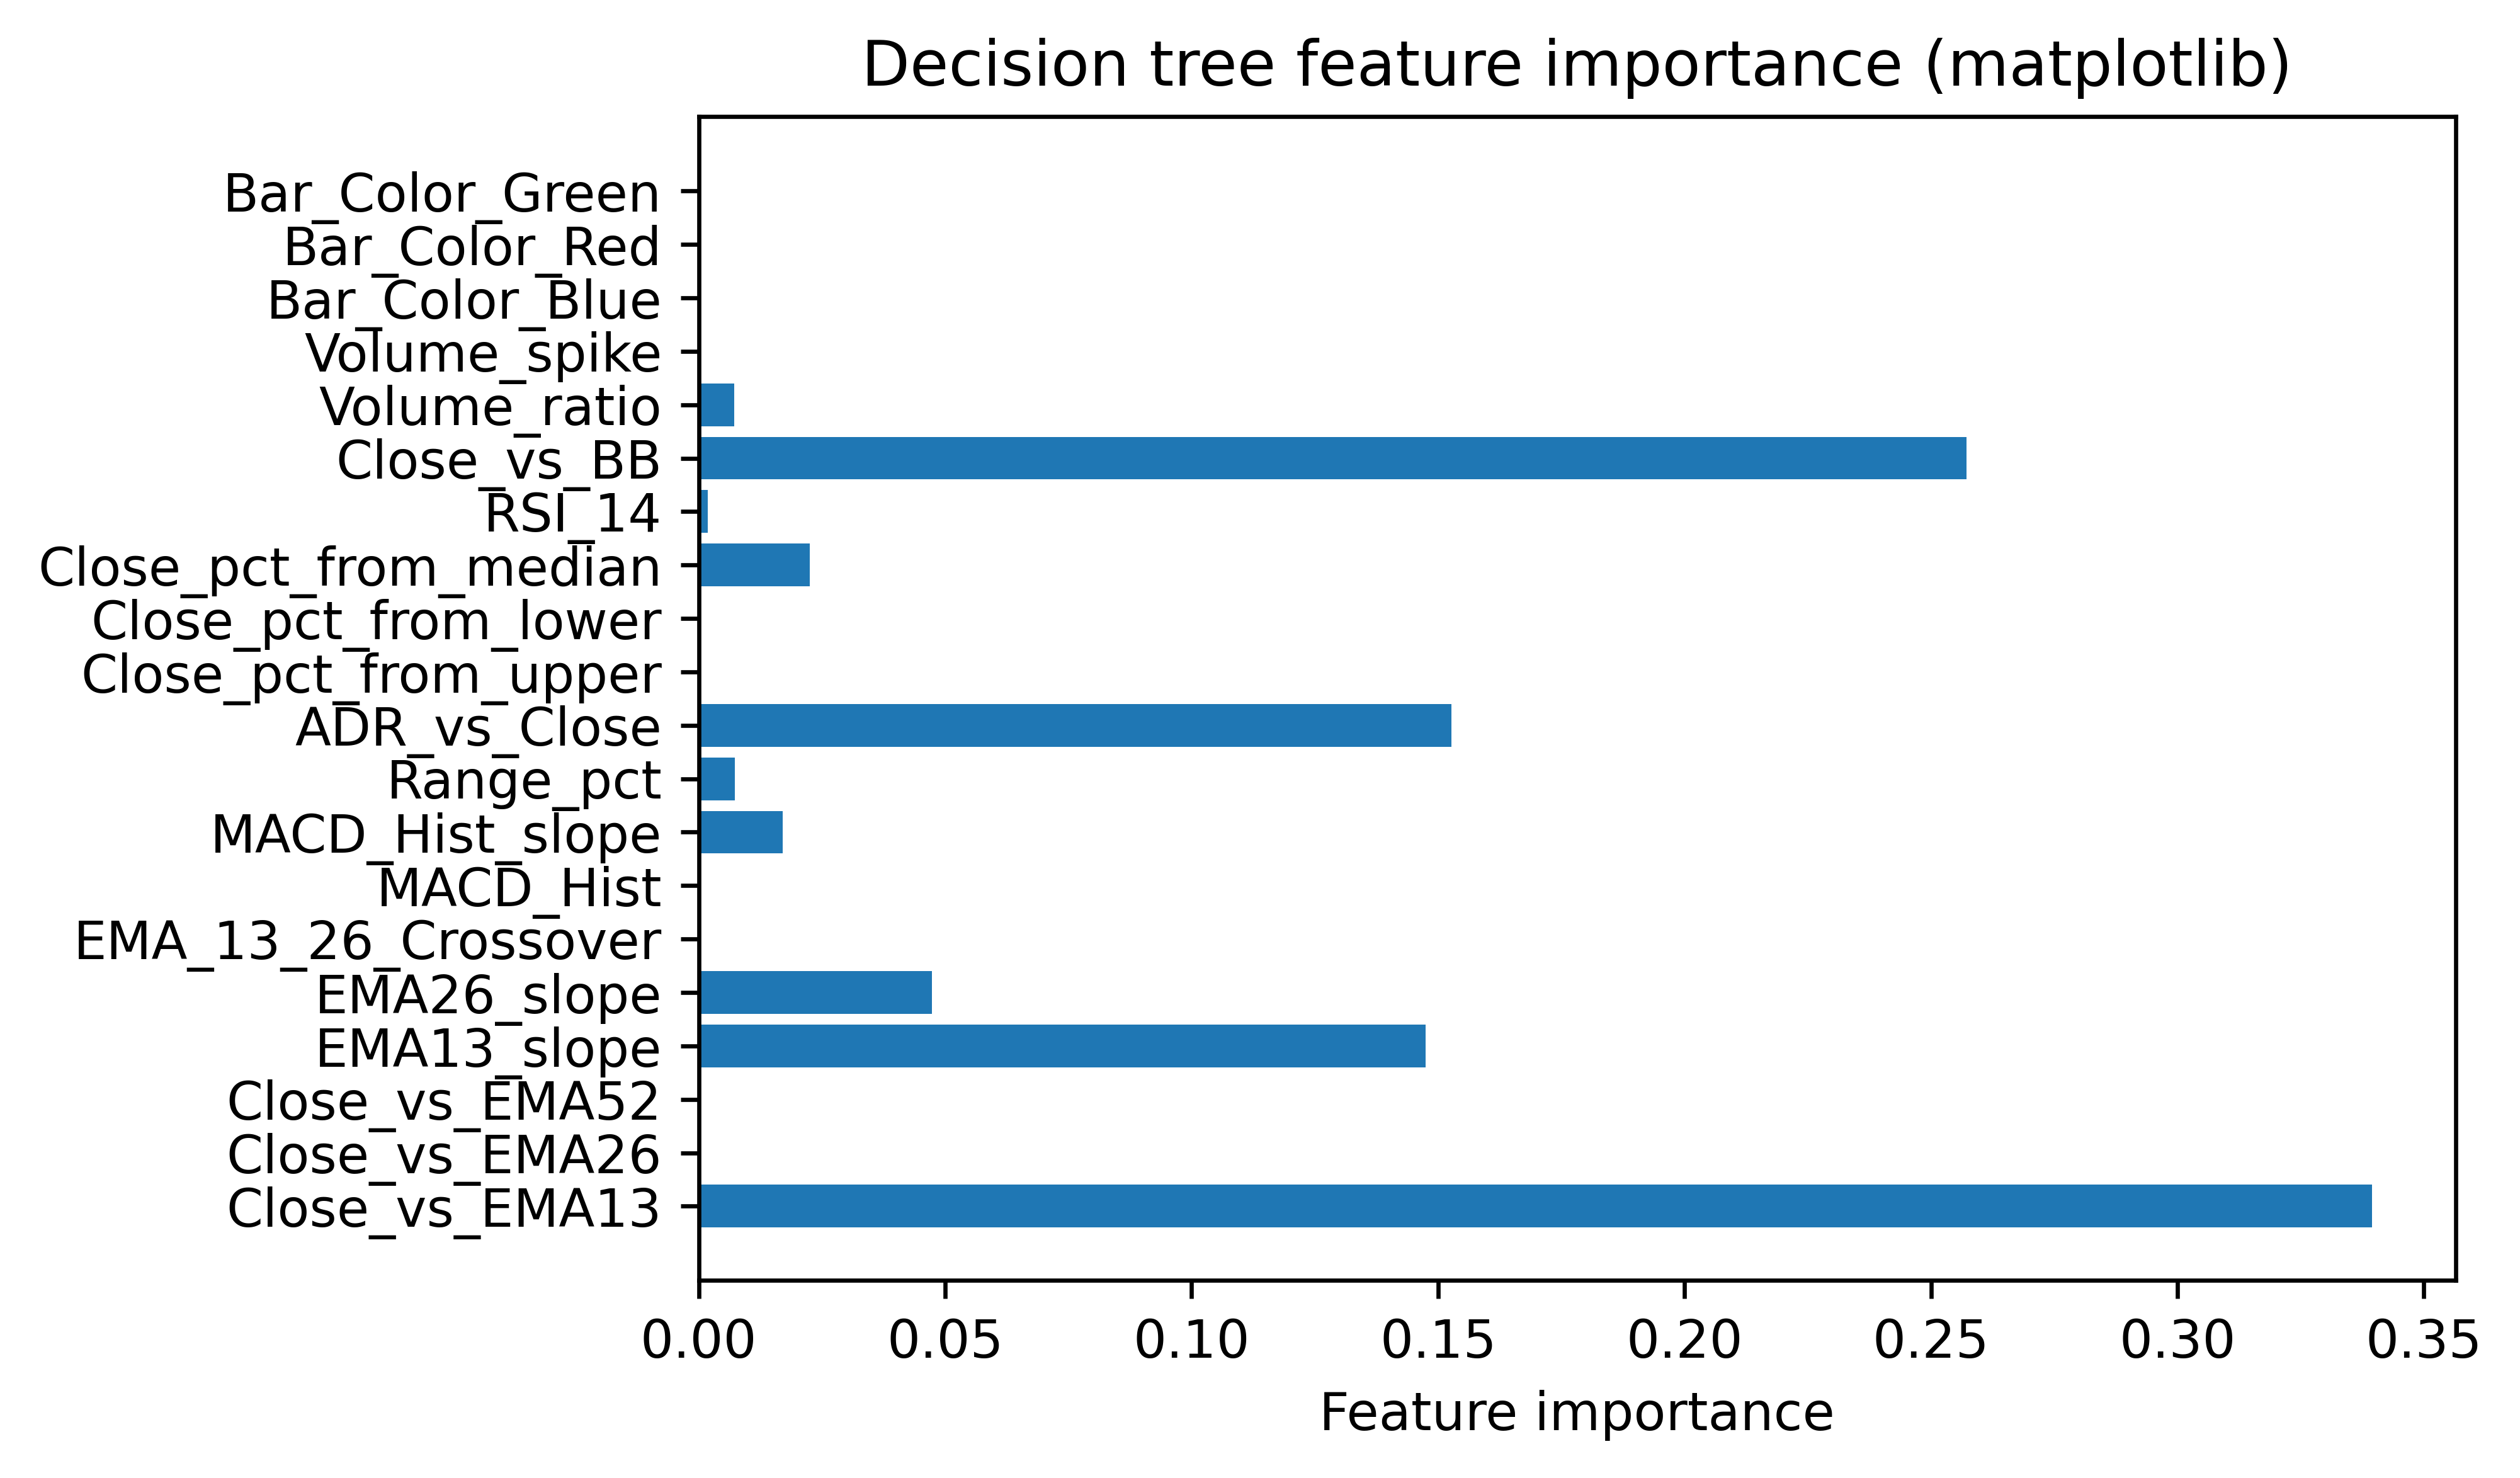

Train accuracy: 0.79
Train balanced accuracy: 0.39
Train f1-score: 0.40

Classification report (training set):

              precision    recall  f1-score   support

        Long       0.91      0.06      0.11       911
        None       0.79      0.99      0.88      6211
       Short       0.76      0.13      0.22       878

    accuracy                           0.79      8000
   macro avg       0.82      0.39      0.40      8000
weighted avg       0.80      0.79      0.72      8000


Confusion matrix (training set):


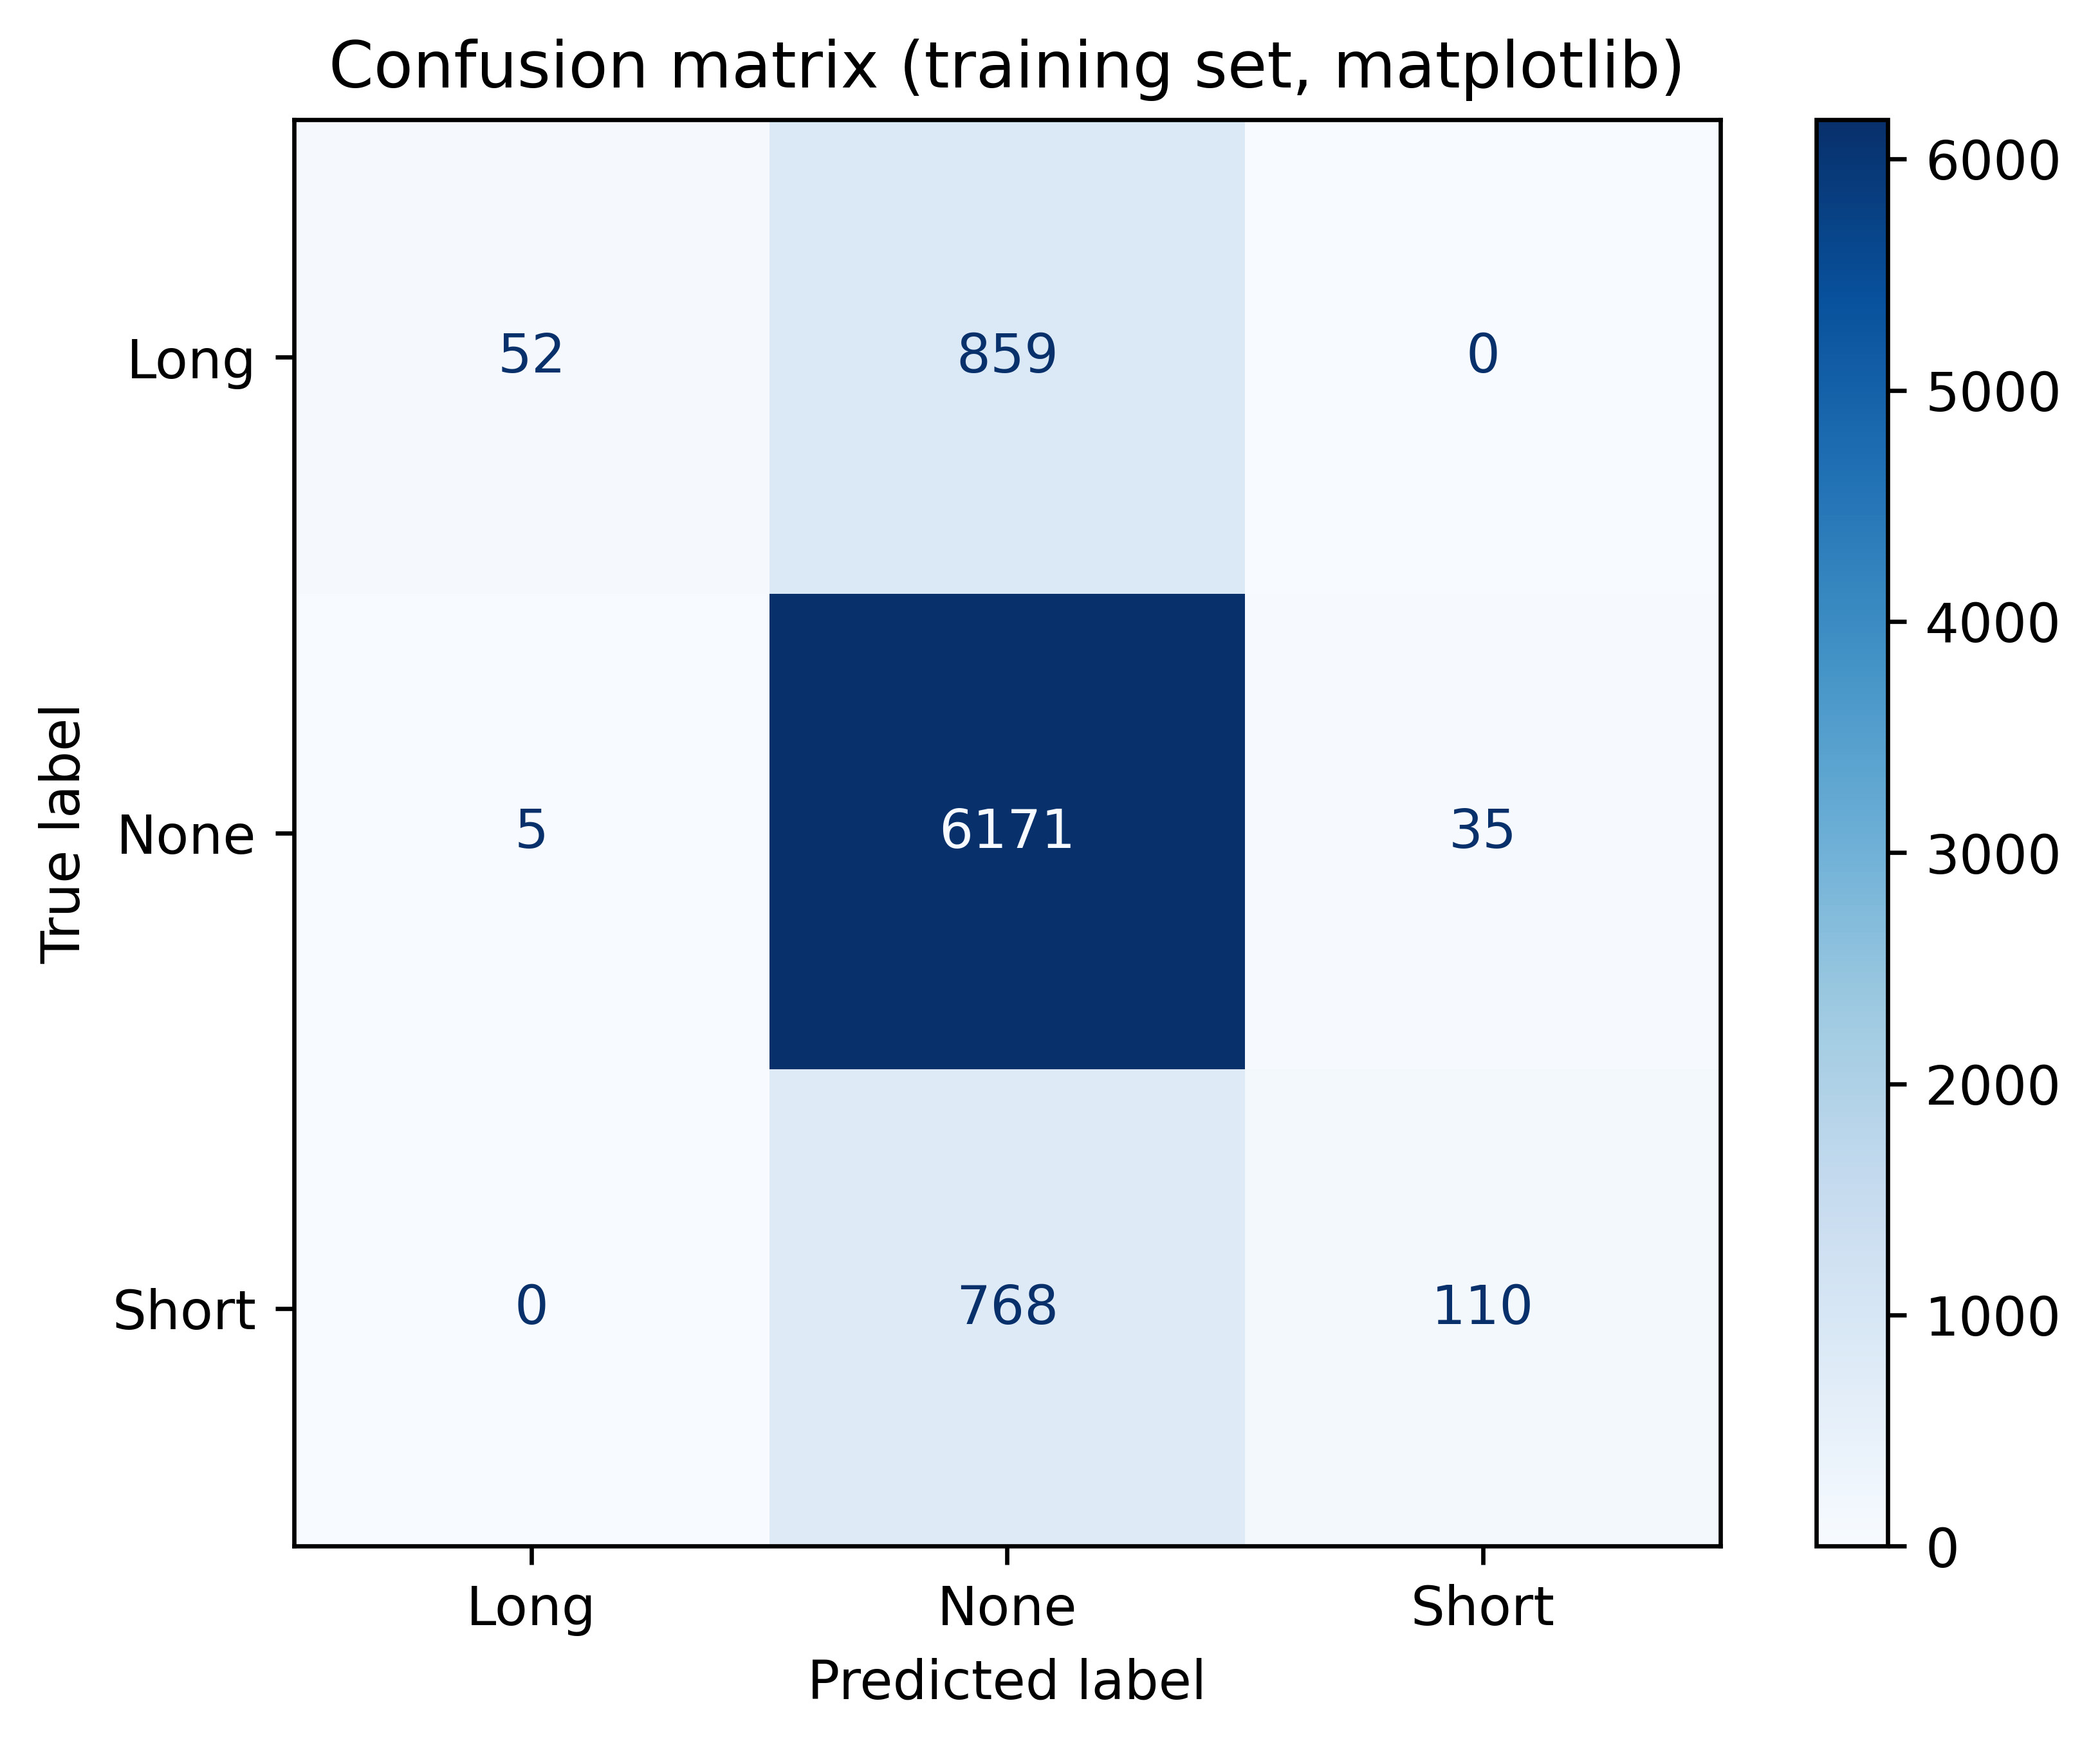

In [17]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# Train the model
model_decision_tree_classifier = DecisionTreeClassifier(
    max_depth=5,
    criterion='entropy',
    min_samples_split=20,
    min_samples_leaf=16,
    random_state=42
)
model_decision_tree_classifier.fit(features_train, labels_train)

# Feature importances
feature_importances_decision_tree = model_decision_tree_classifier.feature_importances_

# Matplotlib version
plt.figure(figsize=(6,4))
plt.barh(X.columns, feature_importances_decision_tree)
plt.xlabel("Feature importance")
plt.title("Decision tree feature importance (matplotlib)")
plt.show()

# --- Evaluation on TRAINING SET ---

train_predictions = model_decision_tree_classifier.predict(features_train)
train_accuracy = accuracy_score(labels_train, train_predictions)
train_balanced_accuracy = balanced_accuracy_score(labels_train, train_predictions)
train_f1_score = f1_score(labels_train, train_predictions, average="macro")
train_conf_matrix = confusion_matrix(labels_train, train_predictions, labels=sorted(df['Trade_Signal'].unique()))
train_class_report = classification_report(labels_train, train_predictions, zero_division=0)

print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Train balanced accuracy: {train_balanced_accuracy:.2f}")
print(f"Train f1-score: {train_f1_score:.2f}")
print("\nClassification report (training set):\n")
print(train_class_report)

print("\nConfusion matrix (training set):")
train_conf_display = ConfusionMatrixDisplay(
    confusion_matrix=train_conf_matrix,
    display_labels=sorted(df['Trade_Signal'].unique())
)
train_conf_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix (training set, matplotlib)")
plt.show()


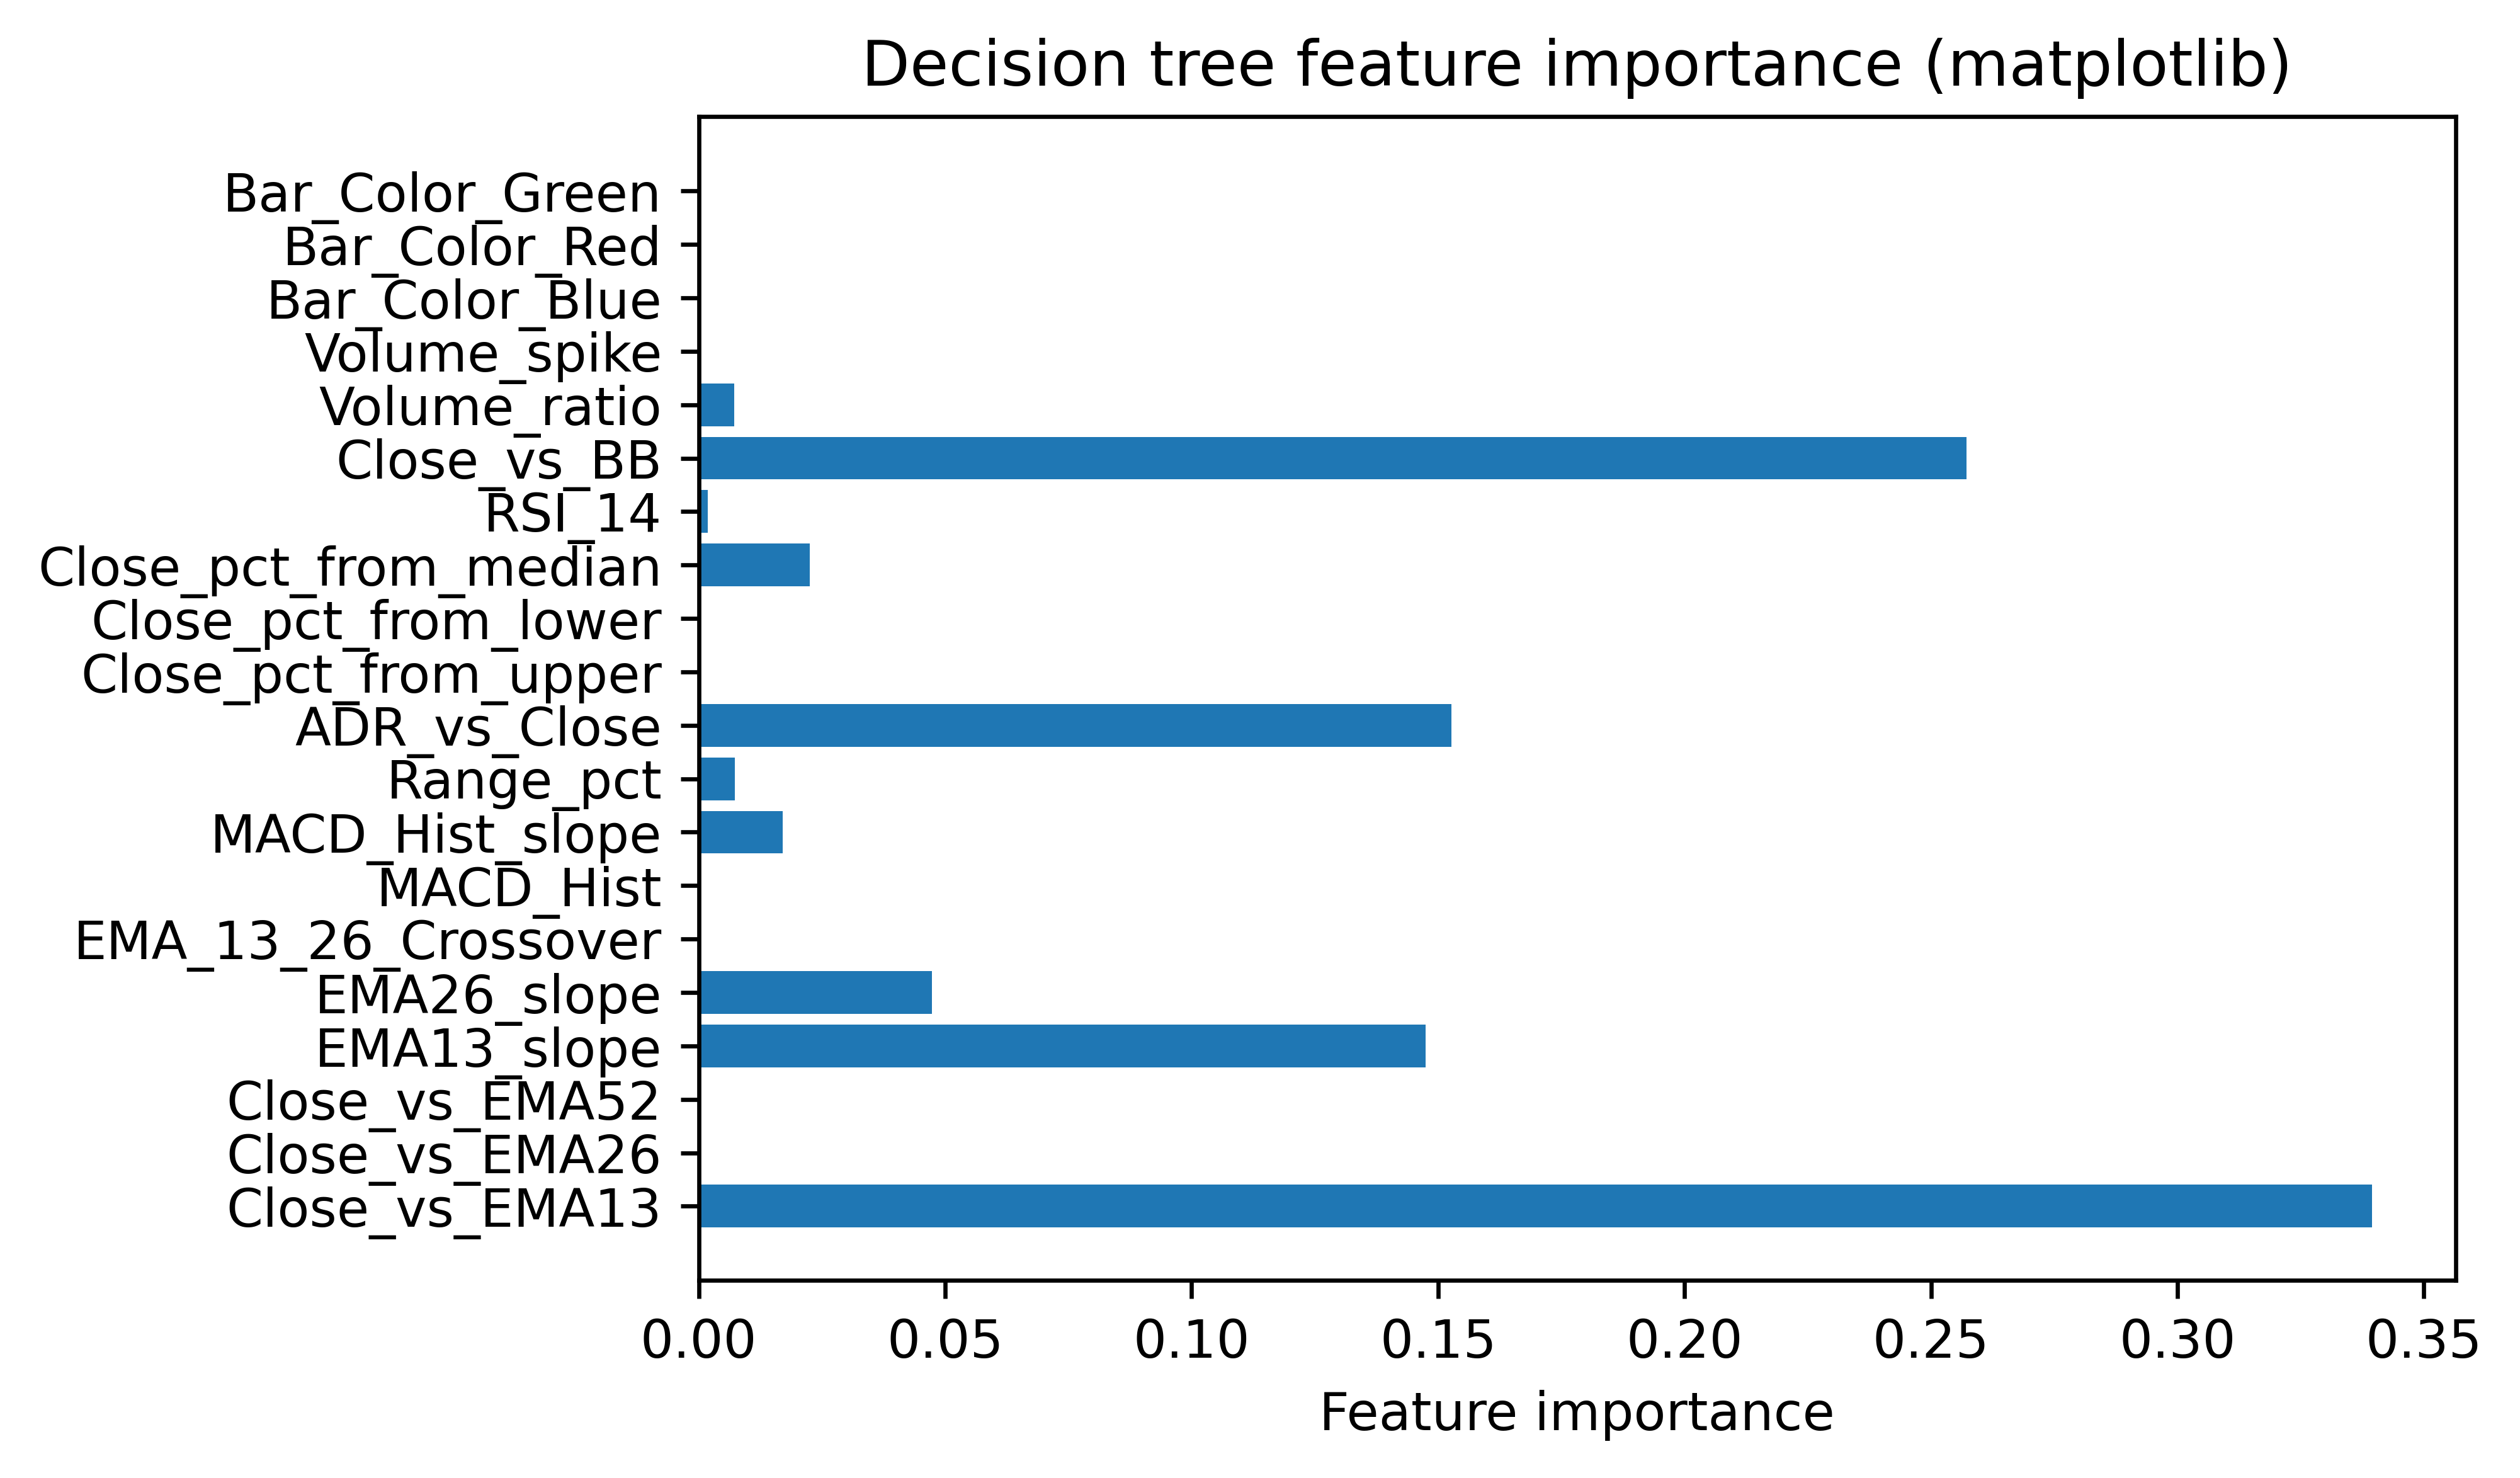

Test accuracy: 0.80
Test balanced accuracy: 0.38
Test f1-score: 0.38
              precision    recall  f1-score   support

        Long       0.62      0.03      0.06       149
        None       0.81      0.98      0.89      1595
       Short       0.57      0.11      0.19       256

    accuracy                           0.80      2000
   macro avg       0.67      0.38      0.38      2000
weighted avg       0.76      0.80      0.74      2000


Confusion matrix (test set):


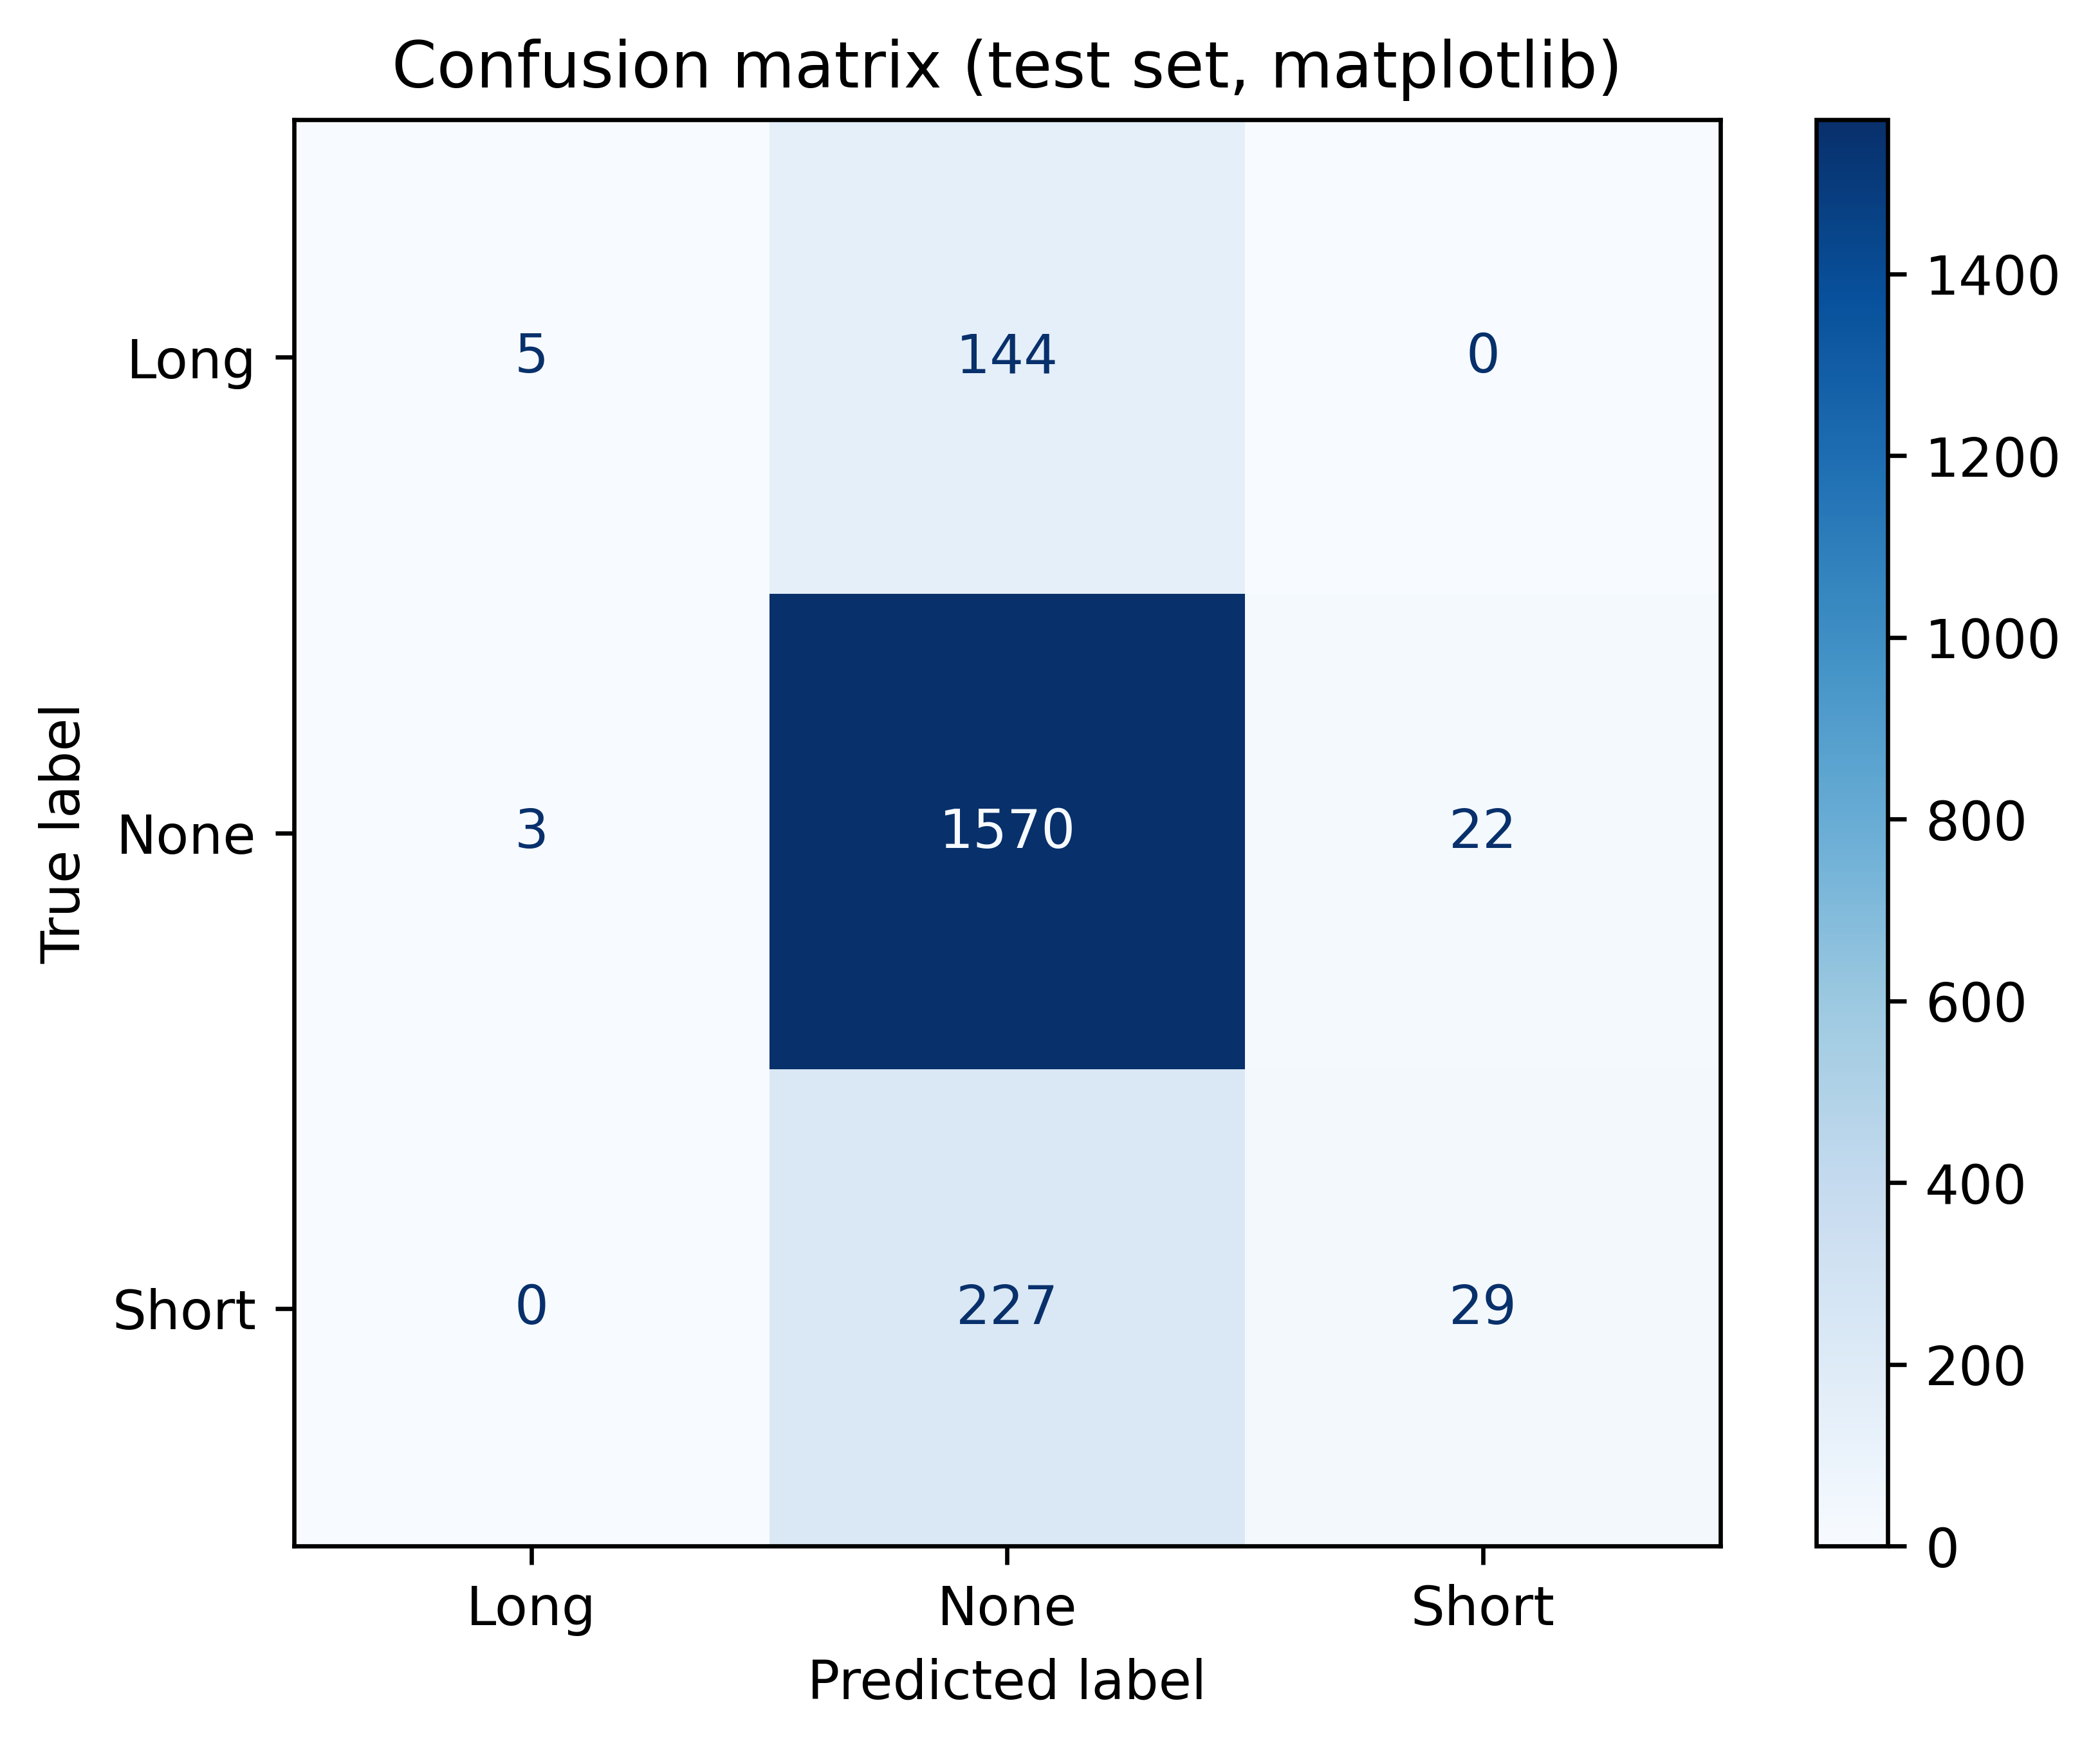

In [16]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# Train the model
model_decision_tree_classifier = DecisionTreeClassifier(
    max_depth=5,
    criterion='entropy',
    min_samples_split=20,
    min_samples_leaf=16,
    random_state=42
)
# Train on the training set
model_decision_tree_classifier.fit(features_train, labels_train)

feature_importances_decision_tree = model_decision_tree_classifier.feature_importances_

# Matplotlib version
plt.figure(figsize=(6,4))
plt.barh(X.columns, feature_importances_decision_tree)
plt.xlabel("Feature importance")
plt.title("Decision tree feature importance (matplotlib)")
plt.show()

# For demonstration, we'll just evaluate the best model on the test set.
test_predictions = model_decision_tree_classifier.predict(features_test)
test_accuracy = accuracy_score(labels_test, test_predictions)
test_balanced_accuracy = balanced_accuracy_score(labels_test, test_predictions)
test_class_report = classification_report(labels_test, test_predictions, zero_division=0)
test_f1_score = f1_score(labels_test, test_predictions, average="macro")
test_conf_matrix = confusion_matrix(labels_test, test_predictions, labels=sorted(df['Trade_Signal'].unique()))
test_class_report = classification_report(labels_test, test_predictions, zero_division=0)

print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test balanced accuracy: {test_balanced_accuracy:.2f}")
print(f"Test f1-score: {test_f1_score:.2f}")
print(test_class_report)
print("\nConfusion matrix (test set):")
test_conf_display = ConfusionMatrixDisplay(
    confusion_matrix=test_conf_matrix,
    display_labels=sorted(df['Trade_Signal'].unique())
)
test_conf_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix (test set, matplotlib)")
plt.show()

Very week performance. I whould like to expect much higher accuracy for Long and Short Labels. May be lets start with the data analysis and focus on trades that will be easier to predict. or you know modify somehow the loss function. 

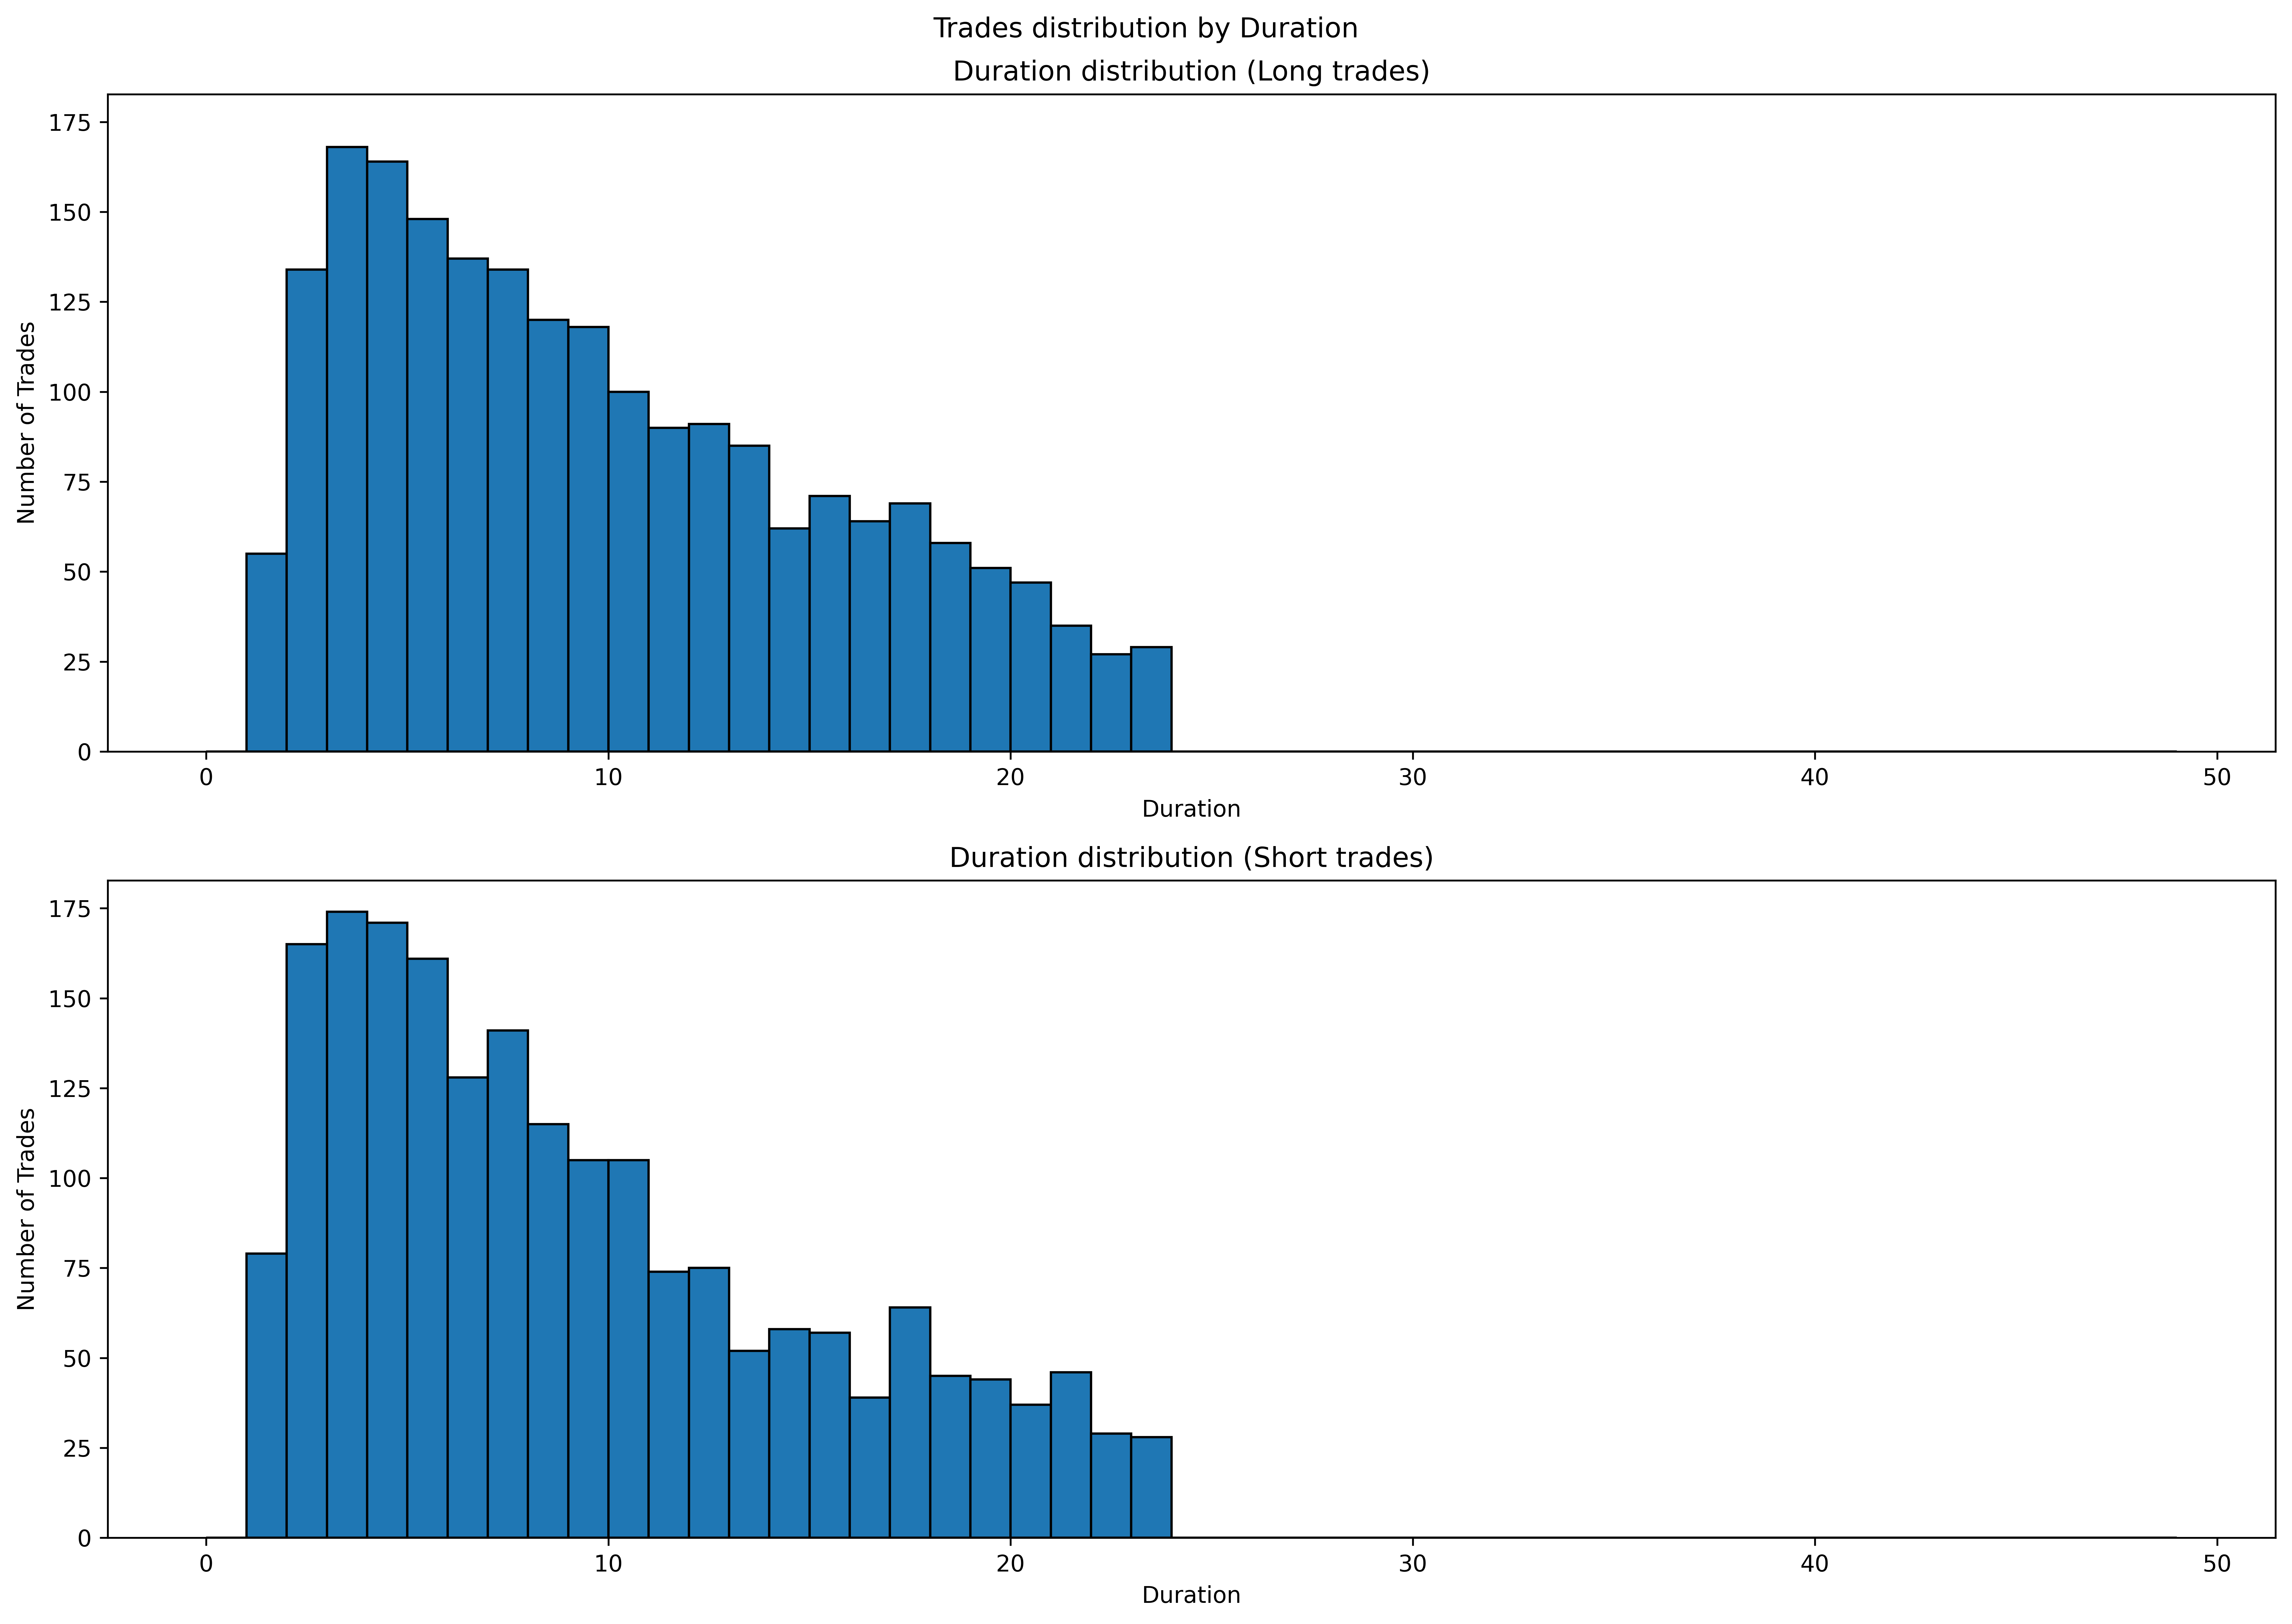

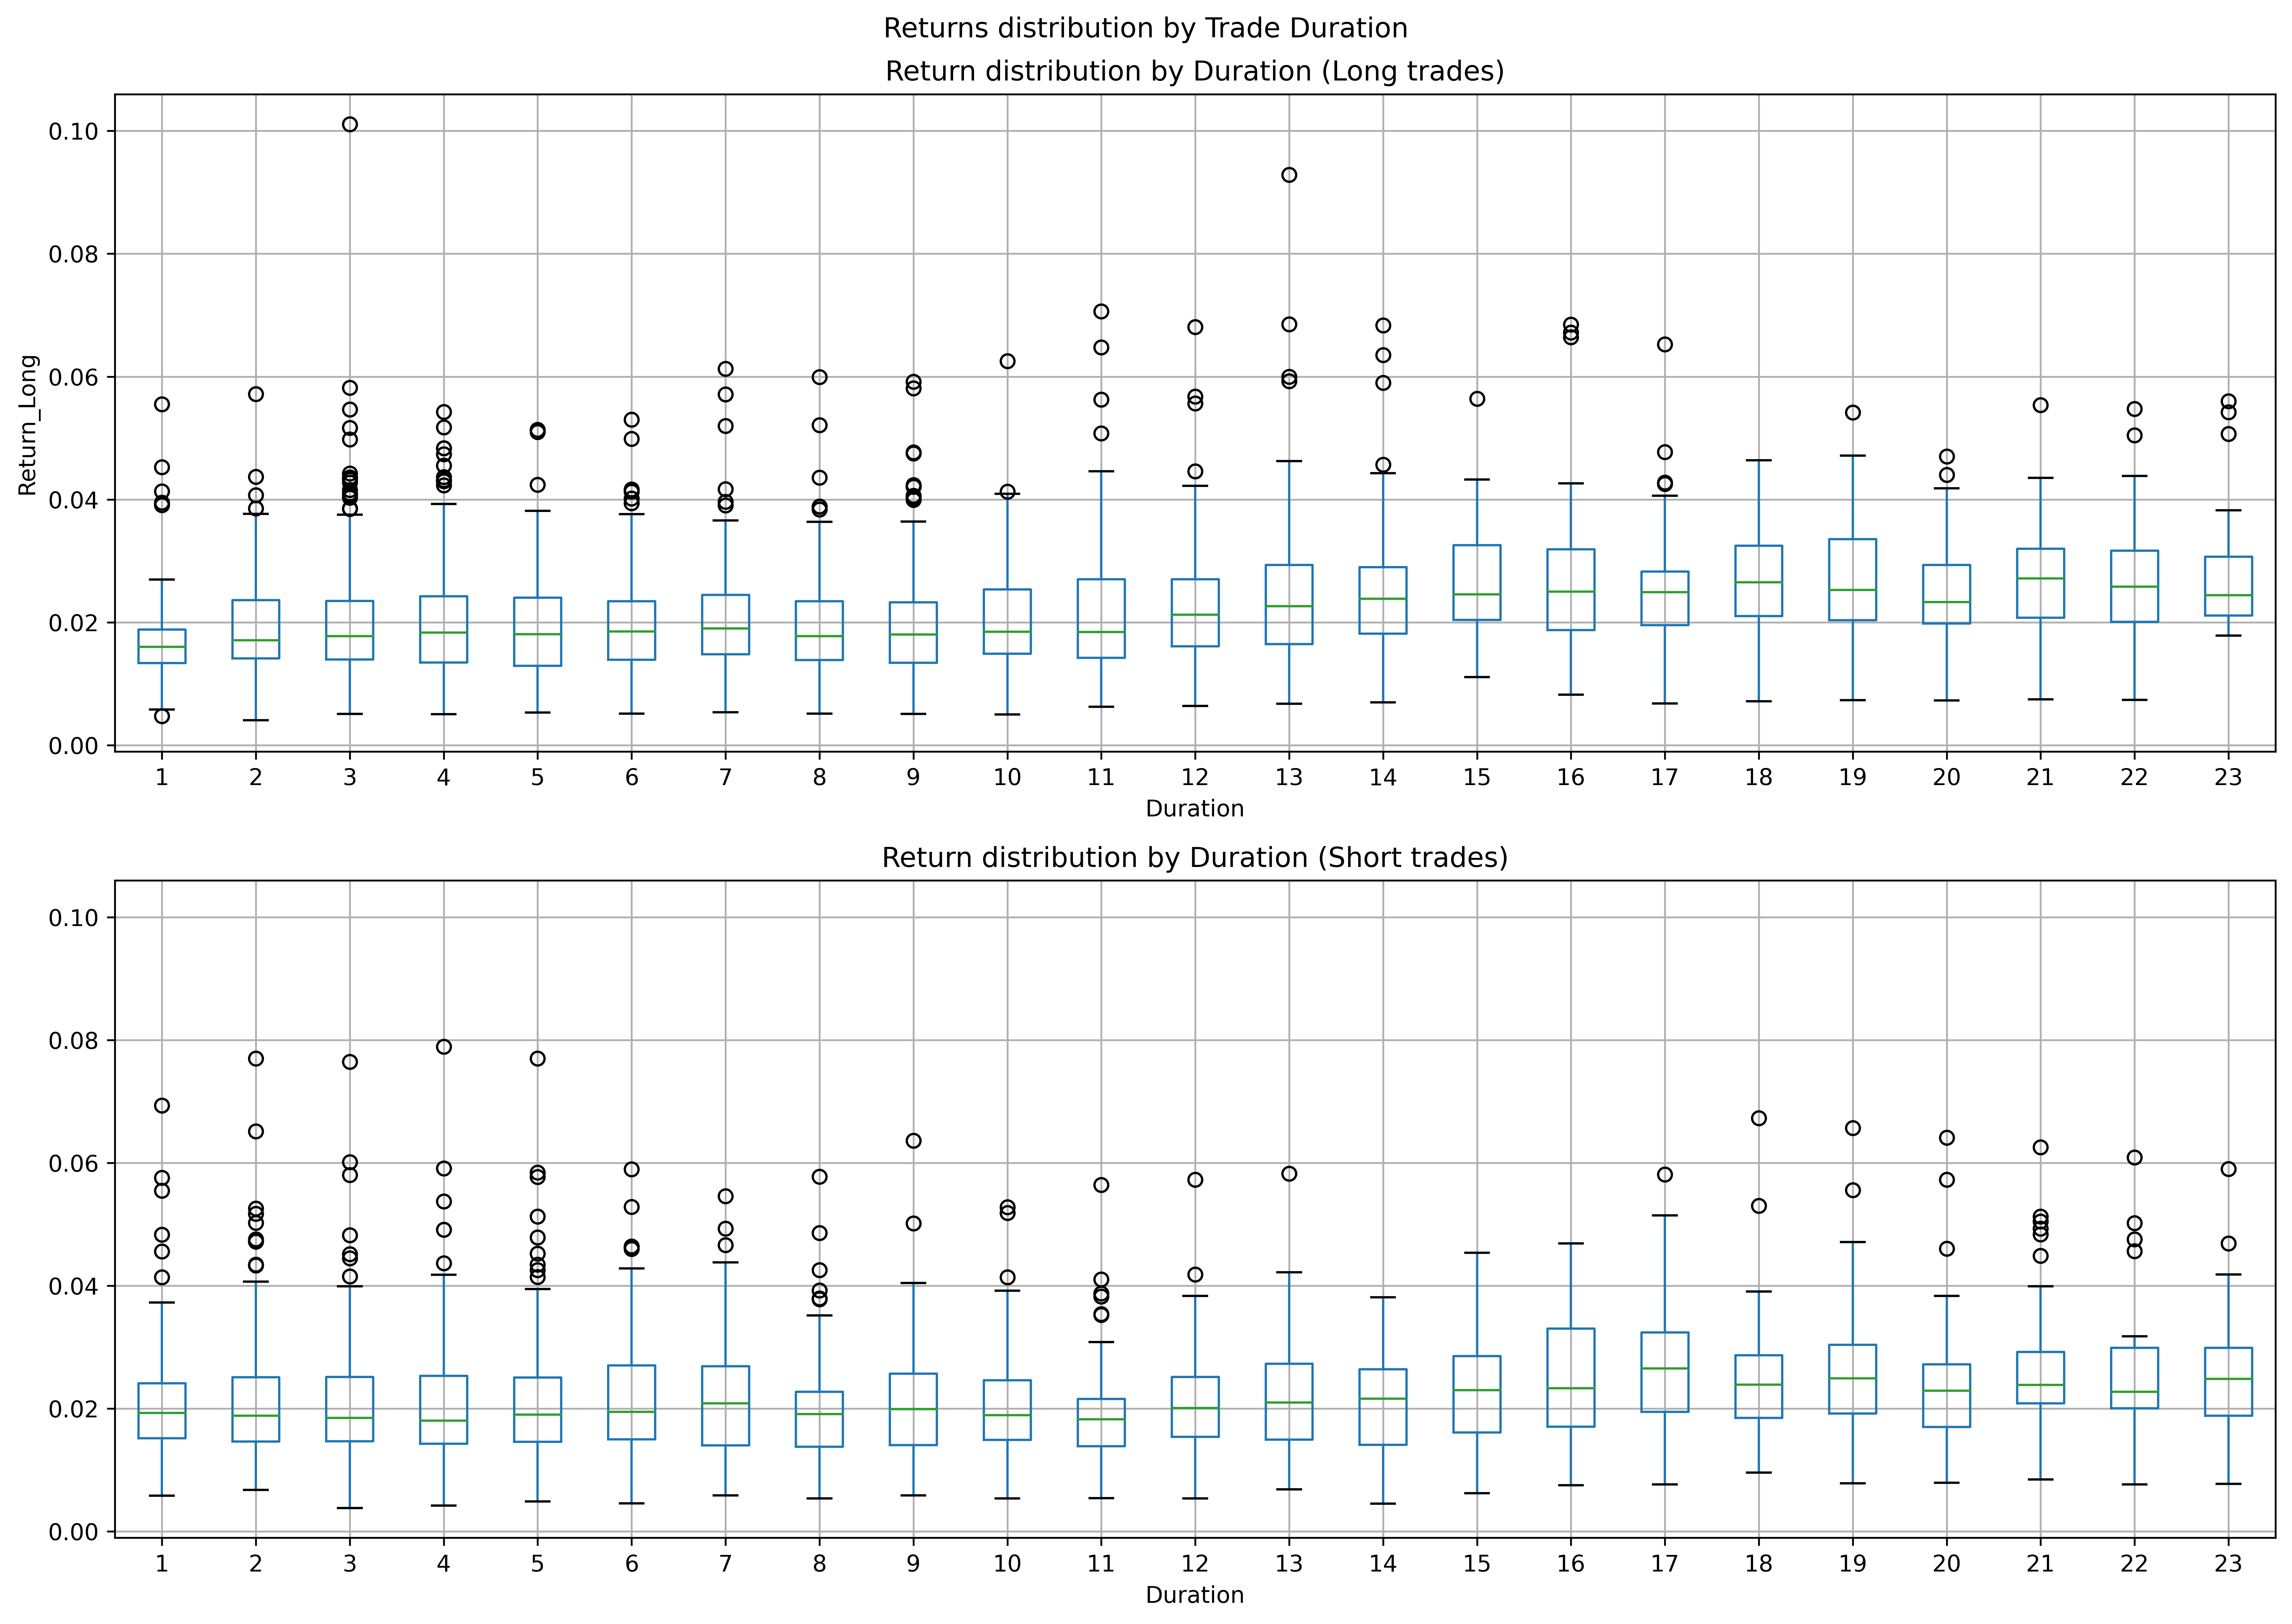

In [ ]:
import matplotlib.pyplot as plt

# Filter data
long_trades = df[(df['Trade_Signal'] == 'Long') & (df['Duration'] < 24)]
short_trades = df[(df['Trade_Signal'] == 'Short') & (df['Duration'] < 24)]

# --- HISTOGRAMS ---

# Create two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharey=True)

# Histogram for Long trades
axes[0].hist(long_trades['Duration'], bins=range(0, 24), edgecolor='black')
axes[0].set_title('Duration distribution (Long trades)')
axes[0].set_xlabel('Duration')
axes[0].set_ylabel('Number of Trades')

# Histogram for Short trades
axes[1].hist(short_trades['Duration'], bins=range(0, 24), edgecolor='black')
axes[1].set_title('Duration distribution (Short trades)')
axes[1].set_xlabel('Duration')
axes[1].set_ylabel('Number of Trades')

# General figure settings
plt.suptitle('Trades distribution by Duration')
plt.tight_layout()
plt.show()

# --- BOXPLOTS ---

# Create two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharey=True)

# Boxplot for Long trades
long_trades.boxplot(column='Return_Long', by='Duration', ax=axes[0])
axes[0].set_title('Return distribution by Duration (Long trades)')
axes[0].set_xlabel('Duration')
axes[0].set_ylabel('Return_Long')

# Boxplot for Short trades
short_trades.boxplot(column='Return_Short', by='Duration', ax=axes[1])
axes[1].set_title('Return distribution by Duration (Short trades)')
axes[1].set_xlabel('Duration')

# General figure settings
plt.suptitle('Returns distribution by Trade Duration')
plt.tight_layout()
plt.show()


In [9]:
# Create a copy of the original Trade_Signal
df['Trade_Signal_max24bars'] = df['Trade_Signal']

# Apply the logic
df.loc[
    (df['Trade_Signal'].isin(['Long', 'Short'])) & (df['Duration'] > 8),
    'Trade_Signal_max24bars'
] = 'None'


In [ ]:
del df['trade_signal_with_duration_less_24']


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

def objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 300, step=50),
        max_depth=trial.suggest_int('max_depth', 3, 20),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )
    tscv = TimeSeriesSplit(n_splits=5)
    score = cross_val_score(
        model, features_train, labels_train, cv=tscv, scoring='accuracy', n_jobs=-1
    ).mean()
    return score


# Run Bayesian Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Extract best hyperparameters
best_params = study.best_params
best_score = study.best_value

# Print best parameters
print(f"Best Max Depth: {best_params['max_depth']}")
print(f"Best No. Trials: {best_params['n_estimators']}")
print(f"Best Min Samples Split: {best_params['min_samples_split']}")
print(f"Best Min Samples Leaf: {best_params['min_samples_leaf']}")
print(f"Best Validation Accuracy: {best_score:.4f}")


[I 2025-04-28 13:07:28,255] A new study created in memory with name: no-name-f8a976a1-9c92-4b84-958d-51d5647ec546
[I 2025-04-28 13:07:31,857] Trial 0 finished with value: 0.4835708927231808 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.4835708927231808.
[I 2025-04-28 13:07:32,864] Trial 1 finished with value: 0.7021755438859715 and parameters: {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7021755438859715.
[I 2025-04-28 13:07:35,291] Trial 2 finished with value: 0.6853713428357089 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7021755438859715.
[I 2025-04-28 13:07:37,488] Trial 3 finished with value: 0.7240810202550637 and parameters: {'n_estimators': 250, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 3 with value

Best Max Depth: 15
Best No. Trials: 200
Best Min Samples Split: 3
Best Min Samples Leaf: 1
Best Validation Accuracy: 0.7682


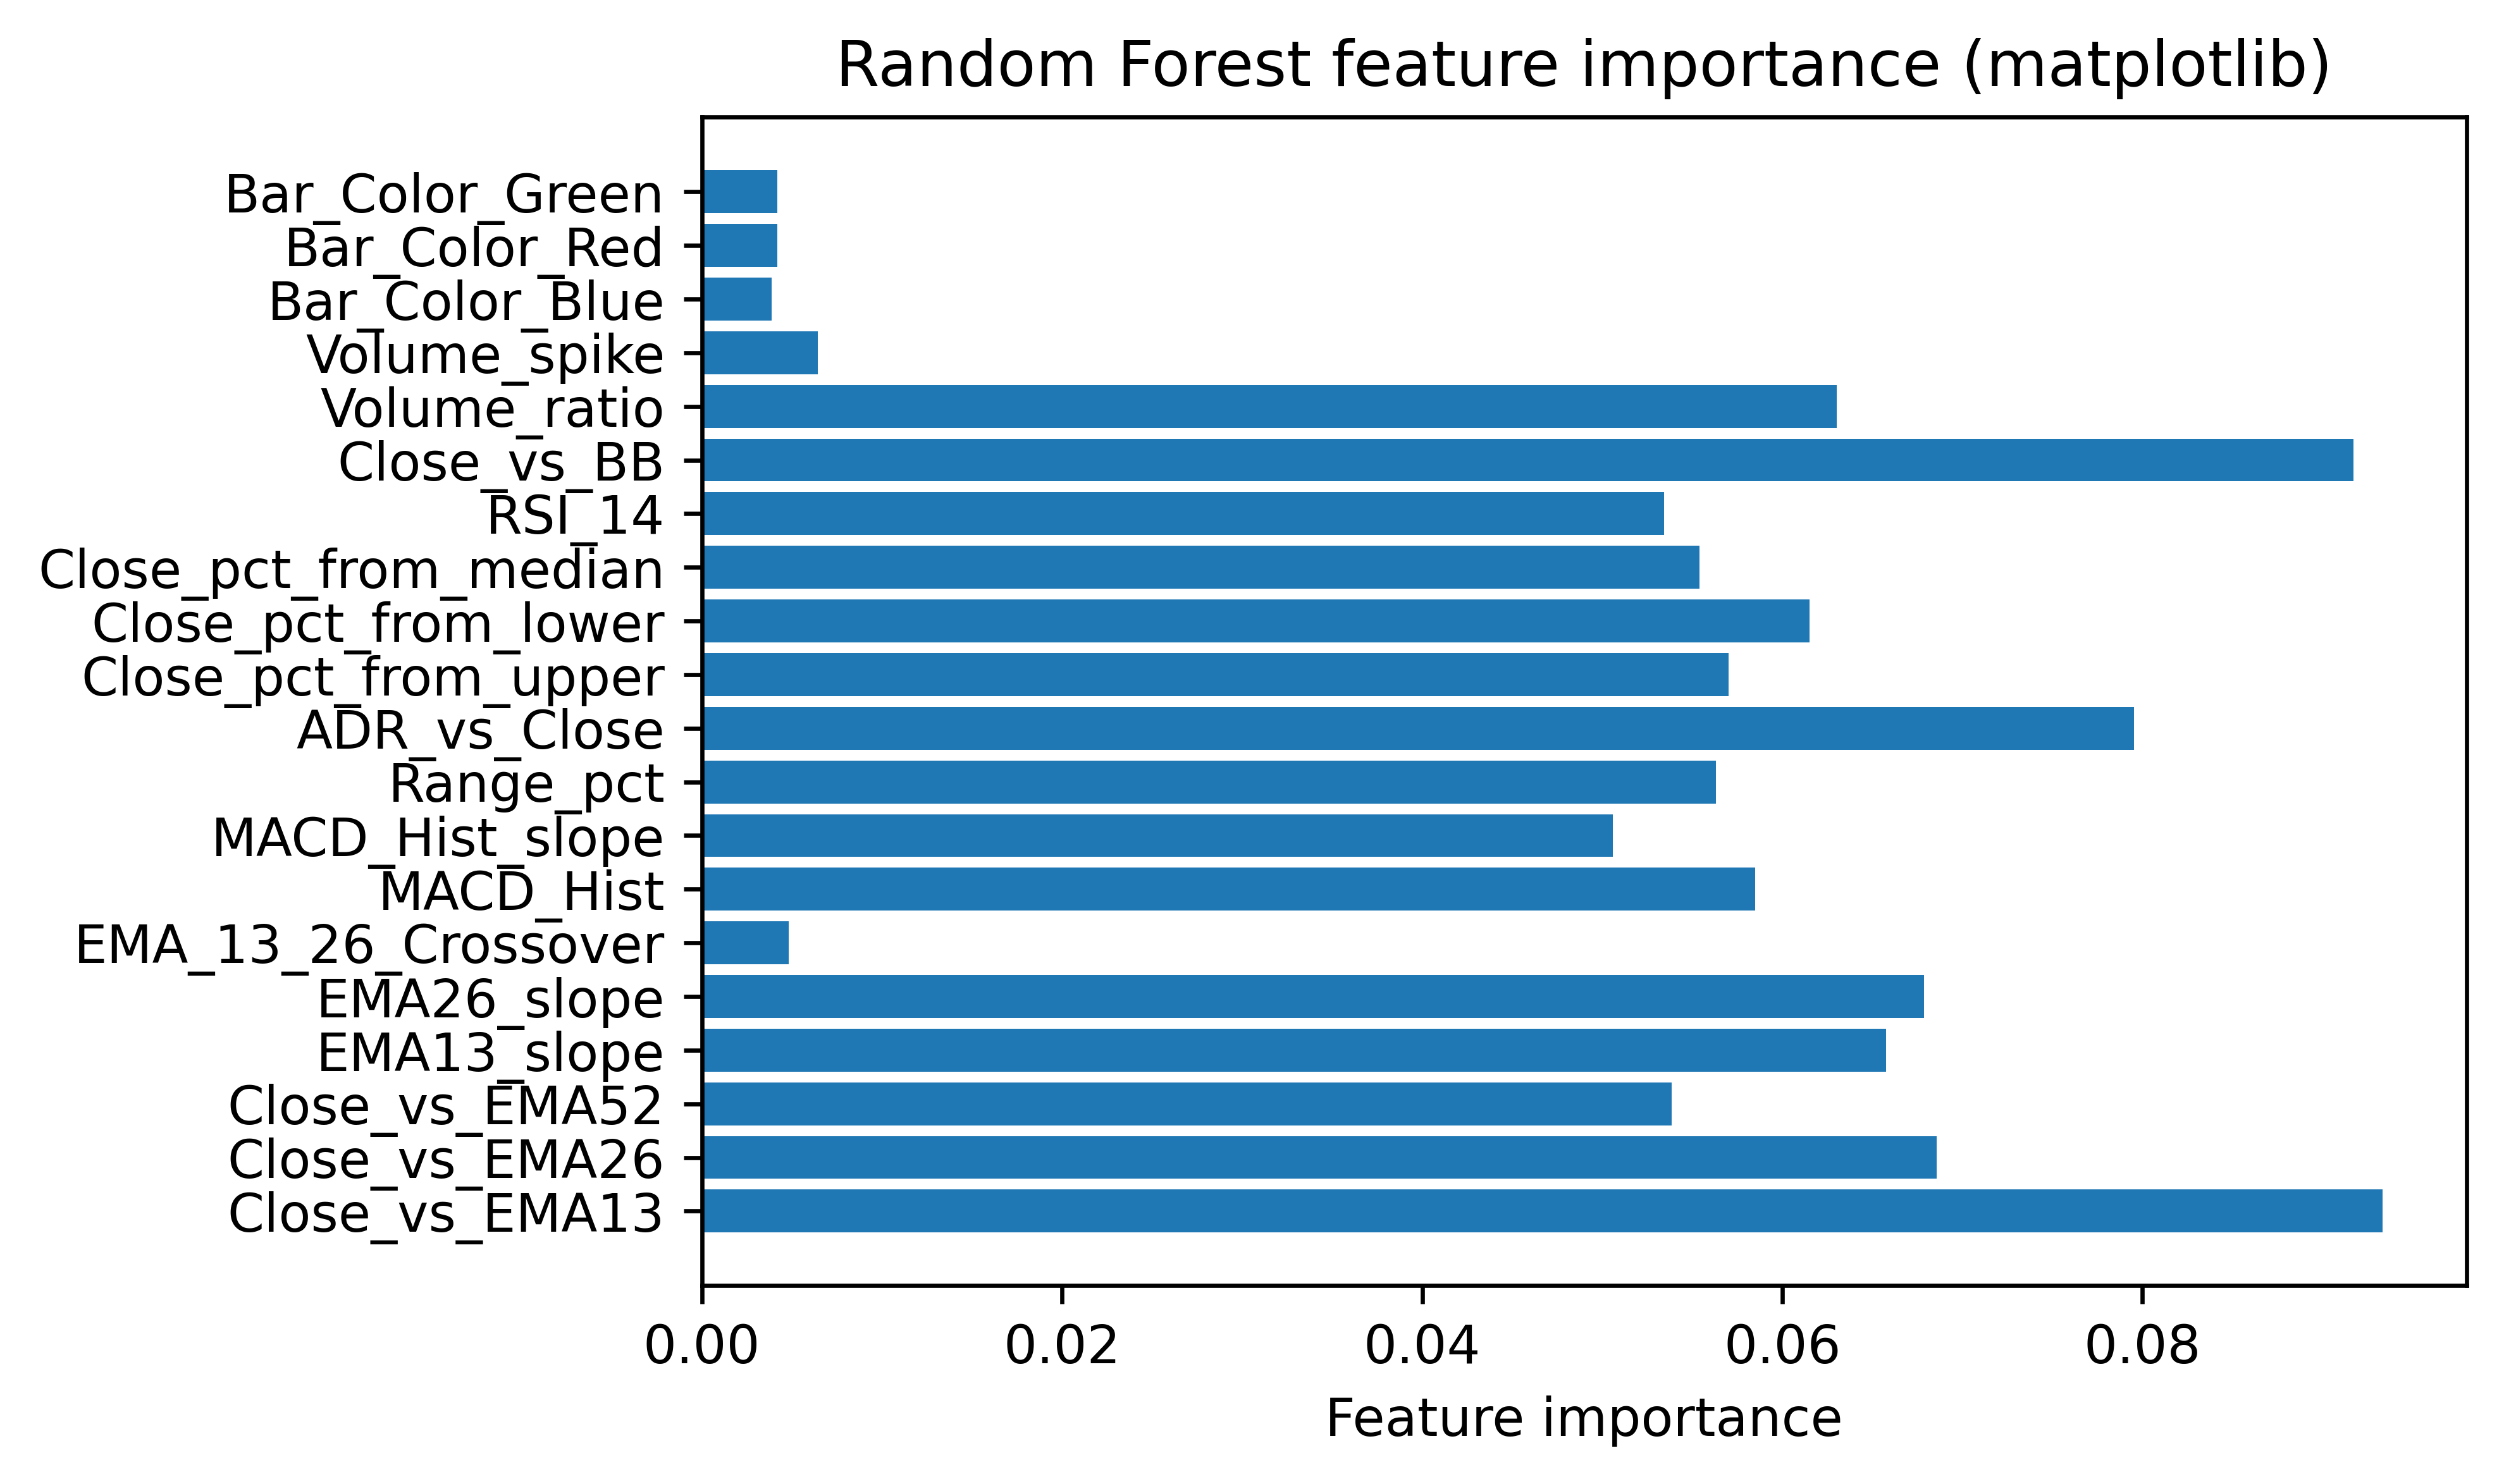

Test accuracy: 0.79
Test balanced accuracy: 0.43
Test f1-score: 0.45

Classification report (test set):

              precision    recall  f1-score   support

        Long       0.35      0.17      0.23       149
        None       0.82      0.95      0.88      1595
       Short       0.55      0.15      0.24       256

    accuracy                           0.79      2000
   macro avg       0.57      0.43      0.45      2000
weighted avg       0.75      0.79      0.75      2000


Confusion matrix (test set):


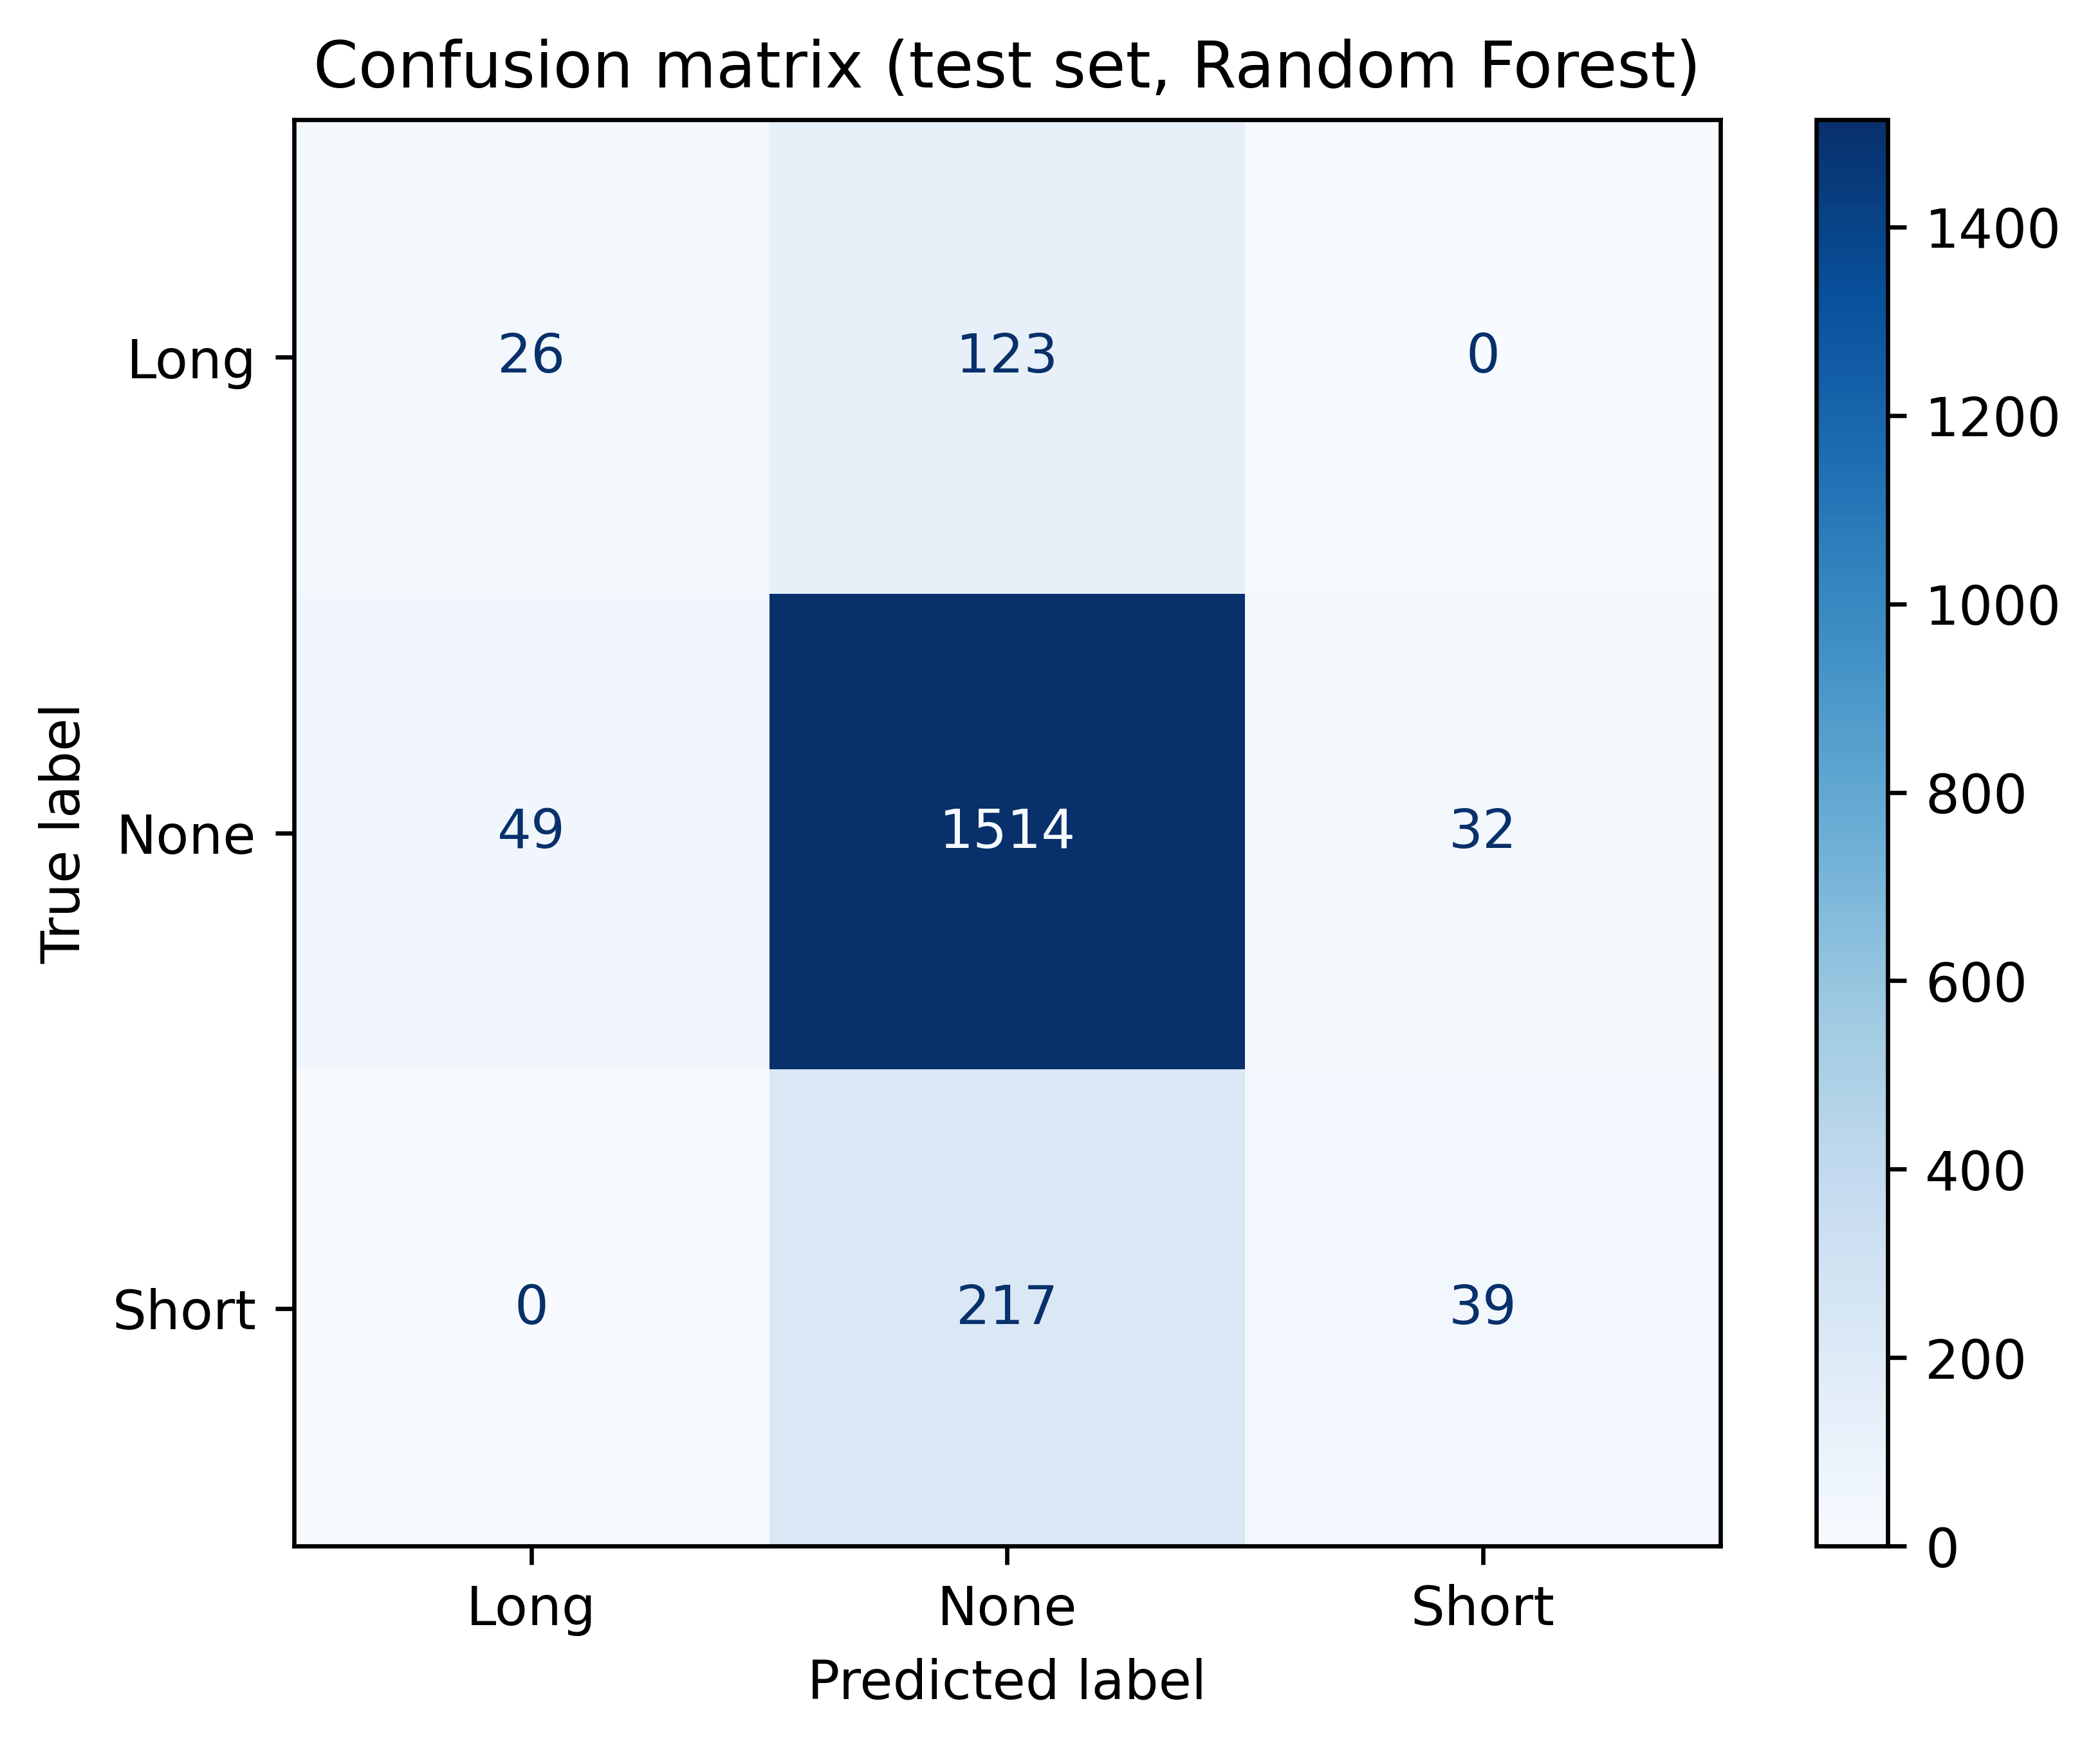

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Define the model
model_random_forest = RandomForestClassifier(
    **study.best_params,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1  # Use all cores for speed
)

model_random_forest.fit(features_train, labels_train)

# --- Feature importances ---
feature_importances_forest = model_random_forest.feature_importances_

plt.figure(figsize=(6, 4))
plt.barh(X.columns, feature_importances_forest)
plt.xlabel("Feature importance")
plt.title("Random Forest feature importance (matplotlib)")
plt.show()

# --- Predictions and Evaluation on the test set ---
test_predictions = model_random_forest.predict(features_test)

test_accuracy = accuracy_score(labels_test, test_predictions)
test_balanced_accuracy = balanced_accuracy_score(labels_test, test_predictions)
test_f1_score = f1_score(labels_test, test_predictions, average="macro")
test_conf_matrix = confusion_matrix(labels_test, test_predictions, labels=sorted(df['Trade_Signal'].unique()))
test_class_report = classification_report(labels_test, test_predictions, zero_division=0)

print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test balanced accuracy: {test_balanced_accuracy:.2f}")
print(f"Test f1-score: {test_f1_score:.2f}")
print("\nClassification report (test set):\n")
print(test_class_report)

# --- Confusion matrix ---
print("\nConfusion matrix (test set):")
test_conf_display = ConfusionMatrixDisplay(
    confusion_matrix=test_conf_matrix,
    display_labels=sorted(df['Trade_Signal'].unique())
)
test_conf_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix (test set, Random Forest)")
plt.show()

In [20]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)


In [21]:
import optuna
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Define objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 5.0),  # for imbalance
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    
    model = xgb.XGBClassifier(**params)
    
    tscv = TimeSeriesSplit(n_splits=5)
    score = cross_val_score(
        model, features_train, labels_train_encoded,
        cv=tscv,
        scoring='recall_macro',  # you can use 'f1_macro' or custom scorer
        n_jobs=-1
    ).mean()
    
    return score

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best parameters and score
print("Best hyperparameters:", study.best_params)
print(f"Best cross-validation accuracy: {study.best_value:.4f}")


[I 2025-04-28 13:14:38,678] A new study created in memory with name: no-name-618cf9dc-f01a-416f-9bb8-0b12a718f886
/Users/Robert/Downloads/ML for Social Sciences JCM072/Term_Paper/localpyenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:14:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Robert/Downloads/ML for Social Sciences JCM072/Term_Paper/localpyenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:14:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Robert/Downloads/ML for Social Sciences JCM072/Term_Paper/localpyenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:14:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, Us

Best hyperparameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.05716584810959595, 'subsample': 0.7068854217118516, 'colsample_bytree': 0.751967392133386, 'gamma': 1.6031415646777885, 'min_child_weight': 10, 'scale_pos_weight': 0.7878116486047392}
Best cross-validation accuracy: 0.4370


/Users/Robert/Downloads/ML for Social Sciences JCM072/Term_Paper/localpyenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[13:18:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.




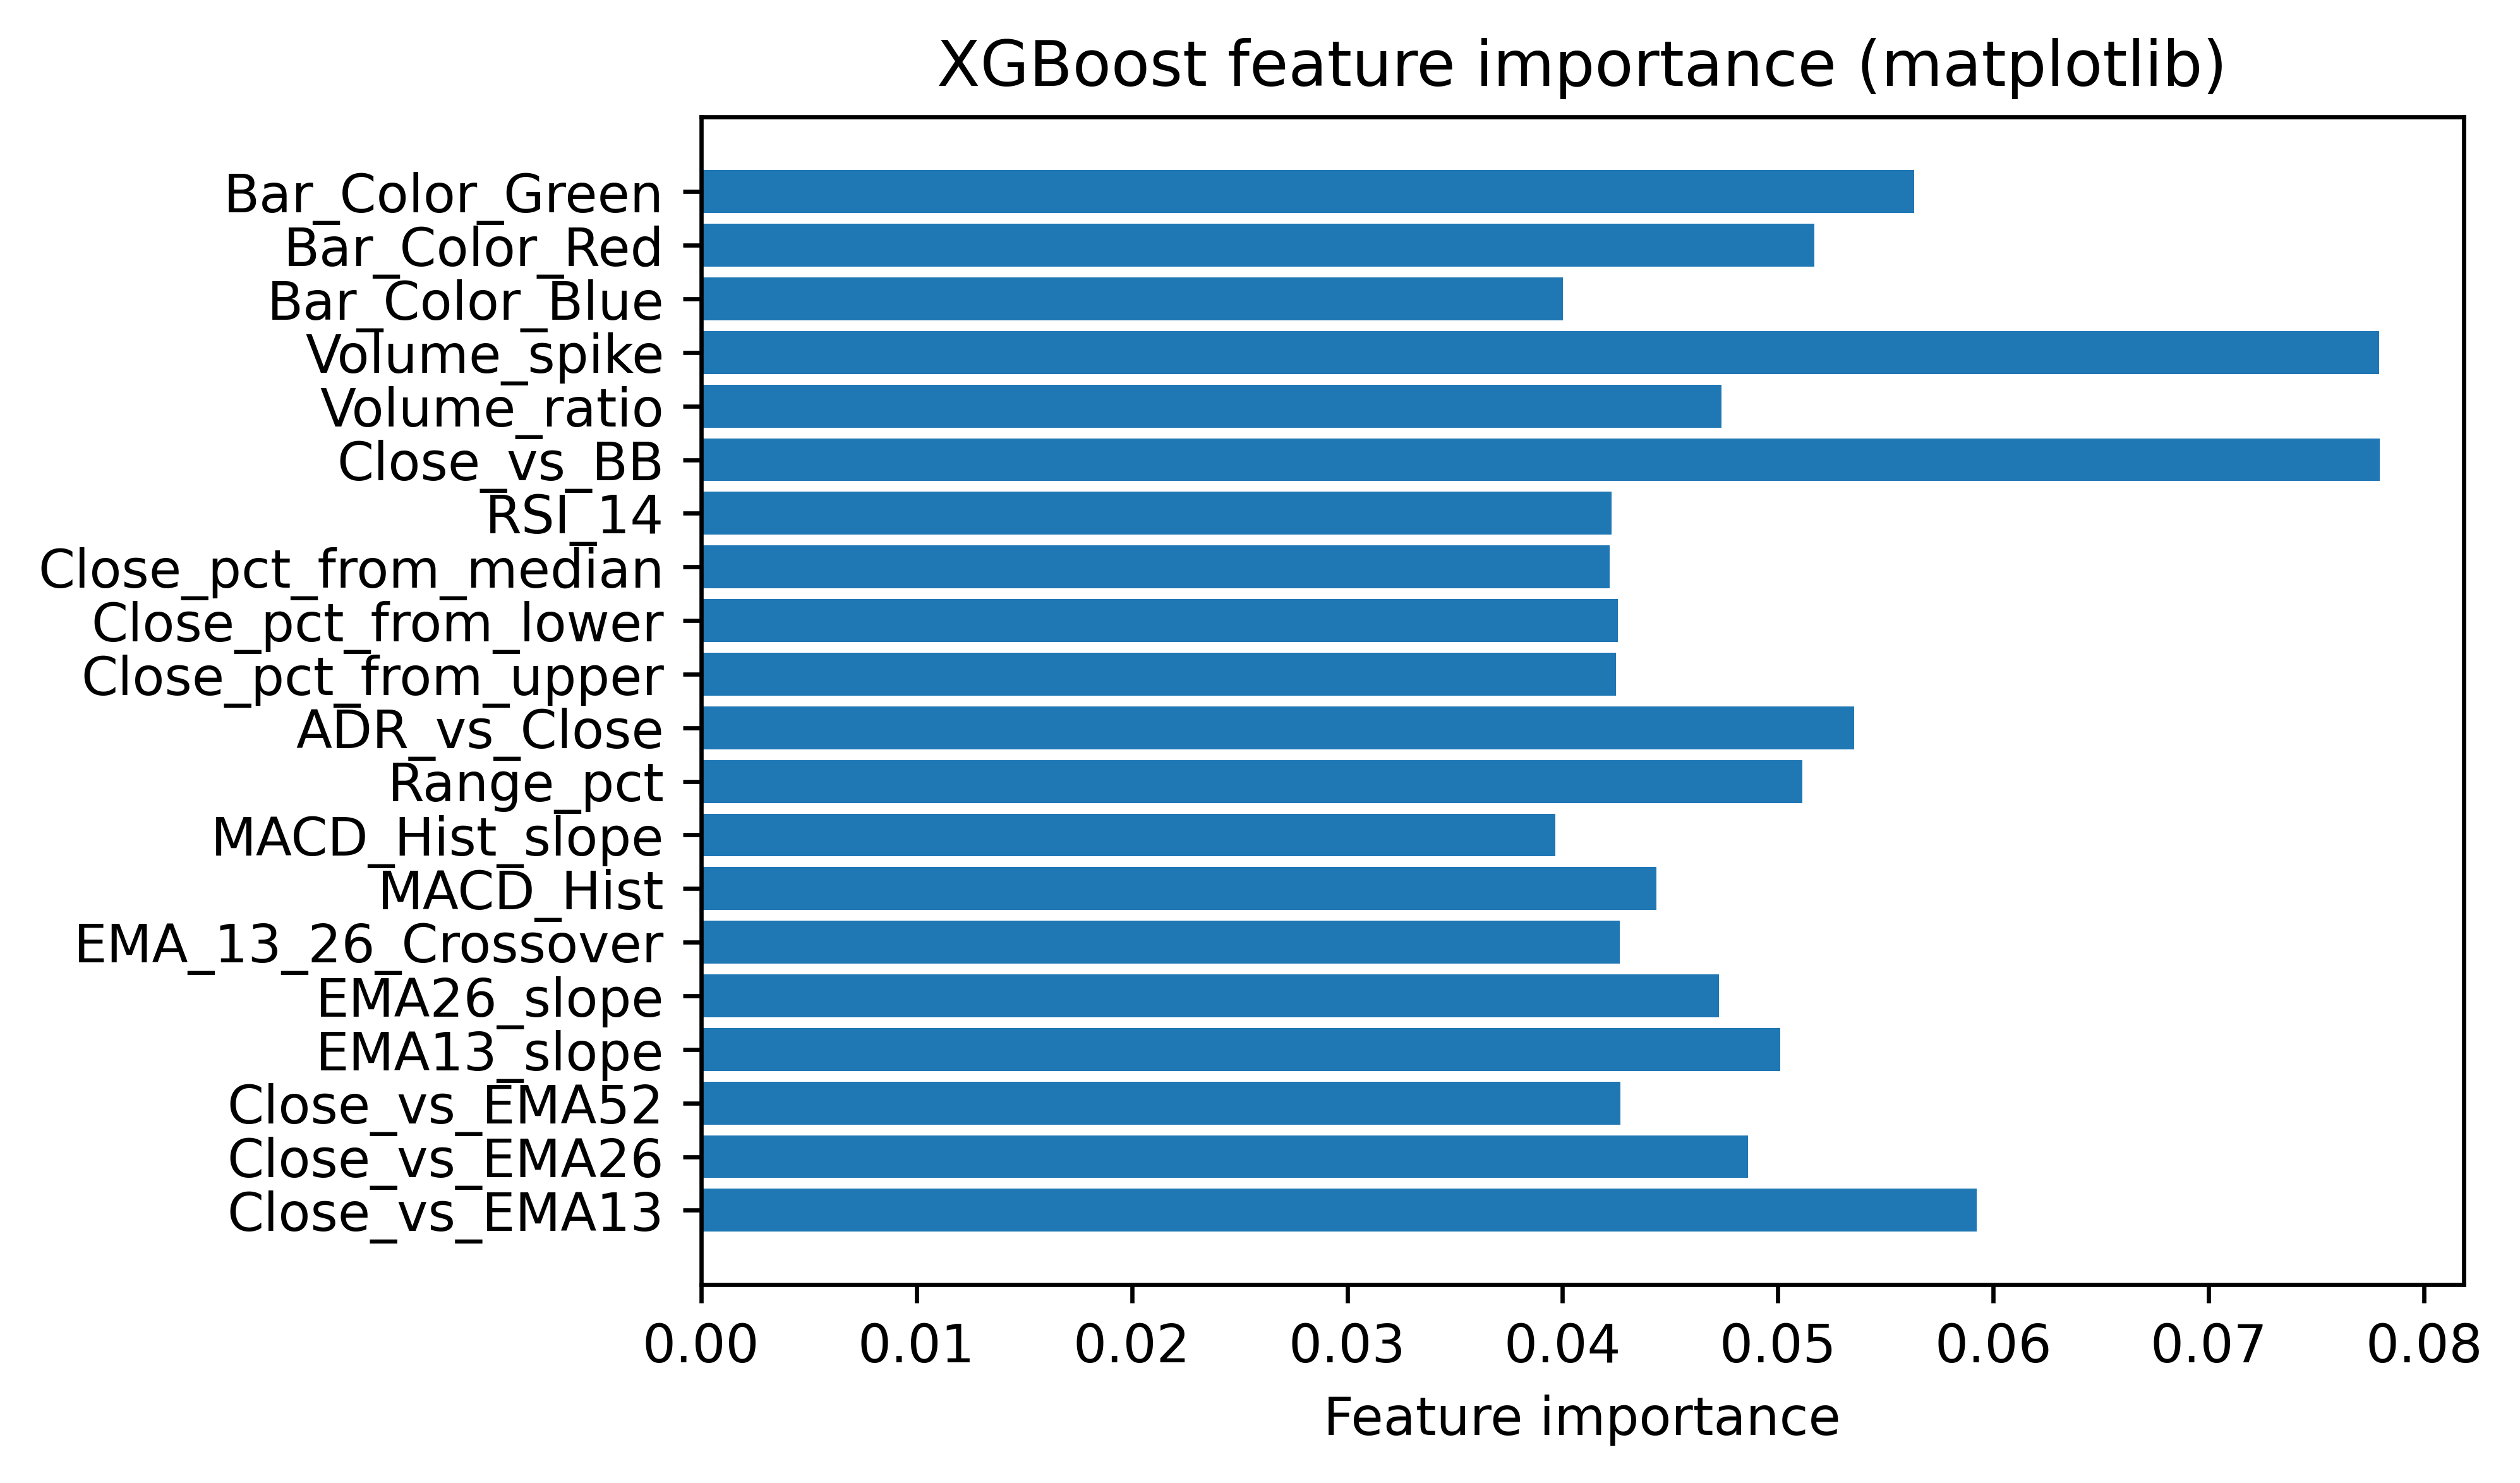

Test accuracy: 0.81
Test balanced accuracy: 0.45
Test f1-score: 0.49

Classification report (test set):

              precision    recall  f1-score   support

        Long       0.49      0.19      0.27       149
        None       0.83      0.96      0.89      1595
       Short       0.64      0.21      0.31       256

    accuracy                           0.81      2000
   macro avg       0.65      0.45      0.49      2000
weighted avg       0.78      0.81      0.77      2000


Confusion matrix (test set):


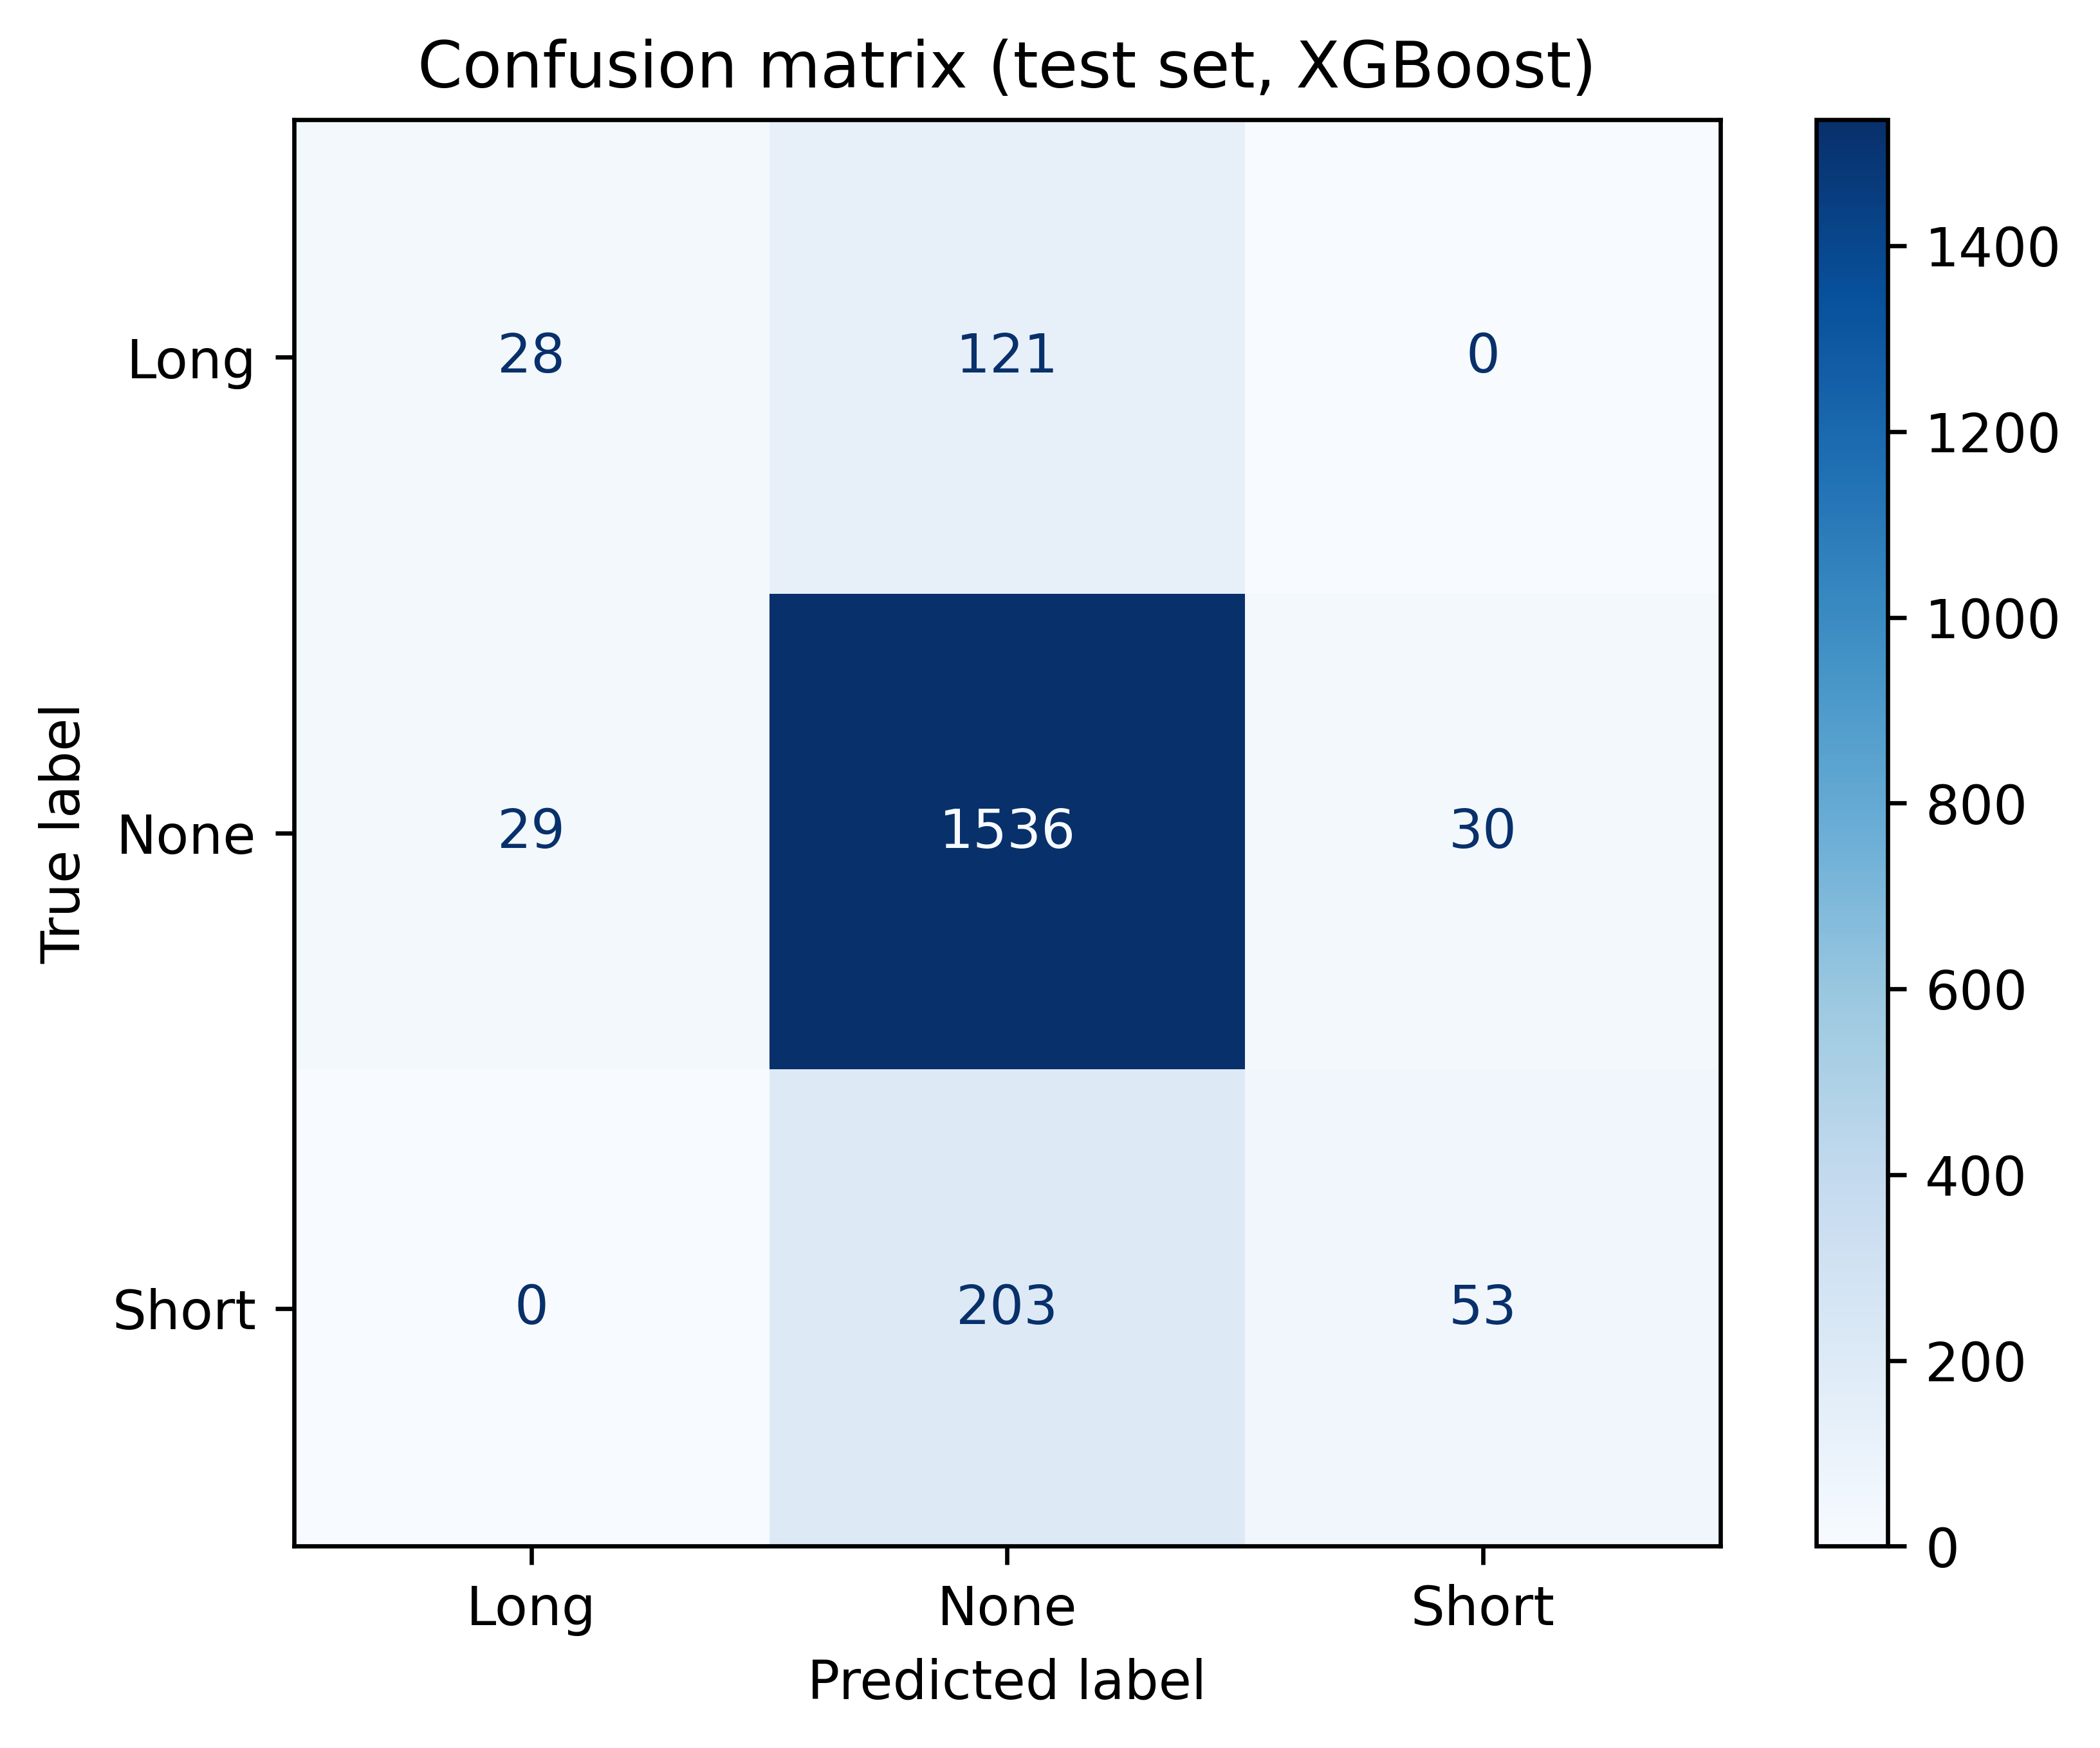

In [22]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
import matplotlib.pyplot as plt

# --- Train XGBoost model ---
model_xgboost = xgb.XGBClassifier(
    **study.best_params,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # fast tree growth (can use 'gpu_hist' if you have GPU)
)

# Train on training set
model_xgboost.fit(features_train, labels_train_encoded)

# --- Feature importances ---
feature_importances_xgb = model_xgboost.feature_importances_

plt.figure(figsize=(6, 4))
plt.barh(X.columns, feature_importances_xgb)
plt.xlabel("Feature importance")
plt.title("XGBoost feature importance (matplotlib)")
plt.show()

# --- Predictions and evaluation on the test set ---
test_predictions = label_encoder.inverse_transform(model_xgboost.predict(features_test))

test_accuracy = accuracy_score(labels_test, test_predictions)
test_balanced_accuracy = balanced_accuracy_score(labels_test, test_predictions)
test_f1_score = f1_score(labels_test, test_predictions, average="macro")
test_conf_matrix = confusion_matrix(labels_test, test_predictions, labels=sorted(df['Trade_Signal'].unique()))
test_class_report = classification_report(labels_test, test_predictions, zero_division=0)

print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test balanced accuracy: {test_balanced_accuracy:.2f}")
print(f"Test f1-score: {test_f1_score:.2f}")
print("\nClassification report (test set):\n")
print(test_class_report)

# --- Confusion matrix ---
print("\nConfusion matrix (test set):")
test_conf_display = ConfusionMatrixDisplay(
    confusion_matrix=test_conf_matrix,
    display_labels=sorted(df['Trade_Signal'].unique())
)
test_conf_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix (test set, XGBoost)")
plt.show()
